In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
    # predicted values
    y_pred: list = None
    y_pred_mape: list = None
    y_pred_bestourmethod: list = None
    y_pred_bestinsidemethod: list = None
    # data related to full set
    fulldescriptors: list = None
    labels: list = None
    top_correlation: list = None
    # data realated to inside and our methods
    inside_methods_rmse: list = None
    bestinsidemethod_rmse: float = 0.0
    bestinsidemethod: str = None
    inside_methods_r2: list = None
    our_methods_rmse: dict = None
    bestourmethod_rmse: float = 0.0
    bestourmethod: str = None
    our_methods_r2: dict = None
    our_methods_name : list = None

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")
CORRCUT = 0.98

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF",'Amino20x4',"BUT14DIOL",\
                        "ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76RC",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}  

howmanydifs = 3
methods = {"PBE" : ["Nuclear Repulsion  :", \
                        "One Electron Energy:", \
                        "Two Electron Energy:", \
                        "Potential Energy   :", \
                        "Kinetic Energy     :", \
                        "E(X)               :"  , \
                        "E(C)               :"  , \
                        "Dispersion correction", \
                        "FINAL SINGLE POINT ENERGY"], 
                "PBE0" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"] ,
                "TPSS" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"],
                "TPSSh" : ["Nuclear Repulsion  :", \
                          "One Electron Energy:", \
                          "Two Electron Energy:", \
                          "Potential Energy   :", \
                          "Kinetic Energy     :", \
                          "E(X)               :"  , \
                          "E(C)               :"  , \
                          "Dispersion correction", \
                          "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData_2/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=True)

Reading dataset:  BH76
Number of samples:  76
Number of basic descriptors:  76

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  Amino20x4
Number of samples:  80
Number of basic descriptors:  80

Reading dataset:  BUT14DIOL
Number of samples:  64
Number of basic descriptors:  64

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  

In [4]:
allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)
for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].y_pred_bestinsidemethod = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


Results for inside and our methods
                                 Dataset  ,  Best inside method  ,  RMSE  ,  Best our method  ,  RMSE
                         BARRIER_HEIGHTS  ,  0  ,    8.201  ,  TPSSh  ,   27.068
                    BARRIER_HEIGHTS_BH76  ,  0  ,   10.387  ,   TPSS  ,   31.874
                 BARRIER_HEIGHTS_BHDIV10  ,  0  ,    9.191  ,   PBE0  ,   14.757
                  BARRIER_HEIGHTS_BHPERI  ,  0  ,    4.407  ,   PBE0  ,   17.811
                 BARRIER_HEIGHTS_BHROT27  ,  1  ,    0.611  ,  TPSSh  ,    2.686
                   BARRIER_HEIGHTS_INV24  ,  2  ,    2.658  ,   PBE0  ,    5.711
                    BARRIER_HEIGHTS_PX13  ,  0  ,   11.730  ,   PBE0  ,   49.956
                  BARRIER_HEIGHTS_WCPT18  ,  0  ,    8.999  ,   PBE0  ,   24.302
             INTRAMOLECULAR_INTERACTIONS  ,  2  ,    0.873  ,   PBE0  ,    4.499
       INTRAMOLECULAR_INTERACTIONS_ACONF  ,  2  ,    0.090  ,   PBE0  ,    1.250
   INTRAMOLECULAR_INTERACTIONS_Amino20x4  ,  1  ,    

In [5]:
setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE_E(X)  
                                PBE0_E(X) 1.00
                                TPSS_E(X) 1.00
                               TPSSh_E(X) 1.00
PBE_Nuclear_Repulsion  
                  PBE_Two_Electron_Energy 1.00
                  PBE_One_Electron_Energy 1.00
                 PBE0_One_Electron_Energy 1.00
                   PBE0_Nuclear_Repulsion 1.00
                 PBE0_Two_Electron_Energy 1.00
                   TPSS_Nuclear_Repulsion 1.00
                 TPSS_Two_Electron_Energy 1.00
                 TPSS_One_Electron_Energy 1.00
                TPSSh_Two_Electron_Energy 1.00
                TPSSh_One_Electron_Energy 1.00
                  TPSSh_Nuclear_Repulsion 1.00
PBE_E(C)  
                                PBE0_E(C) 1.00
                                TPSS_E(C) 1.00
                               TPSSh_E(C) 1.00
PBE_Two_Electron_Energy  
                    PBE_Nuclear_Repulsion 1.00
                  PBE_One_Electron_Energy 1.00
                 PBE0_One_Electron_

[1.00141642] 57.22786875823658
[-2.0018959] -13.570884845321416


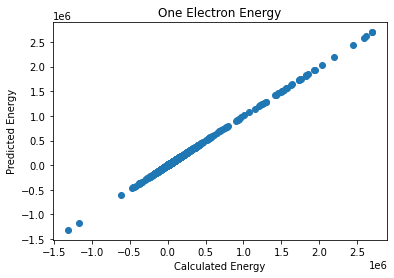

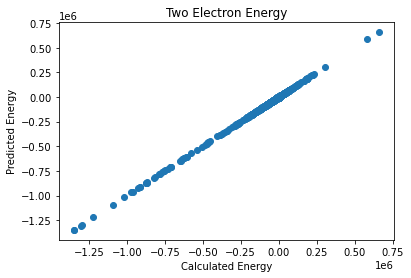

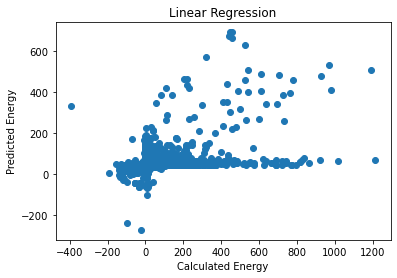

  -11.2200    42.2307 344.72
   61.7112    32.3191  62.52
   19.6516    42.6323  73.79
   19.6516    42.6323  73.79
    3.1397    42.0838 172.23
    3.1397    42.0838 172.23
    1.6184    43.2434 185.57
   26.0171    36.4652  33.44
  -19.4090    42.8385 531.36
   48.9302    35.1603  32.75
  -18.2083    32.7512 700.82
   24.6544    26.1528   5.90
  -83.5521    34.9486 -487.62
  -83.5521    34.9486 -487.62
  -36.9251    43.0541 2609.89
  -36.9251    43.0541 2609.89
  -23.6593    25.9349 4358.76
  -23.6593    25.9349 4358.76
   -8.0006    42.6829 292.27
   -8.0006    42.6829 292.27
 -110.1767    33.2098 -372.59
   18.6755    29.0109  43.35
  -32.8615    43.6496 1418.43
   29.0204    41.7942  36.08
  -69.0493    35.4785 -622.73
  -65.5552    35.0482 -659.54
  -42.5962    43.1832 29228.06
   37.1867    44.9112  18.82
  -17.3944    42.5316 476.79
   26.2415    43.6959  49.91
  -12.6034    42.6700 367.67
   48.7496    43.8807  10.51
   -2.4581    42.6253 224.48
   62.7969    43.6947  35.88
  

In [6]:
# test two linear models to predict energudiff
# LinearRegression
import sklearn.linear_model as lm
linearNR_Two = lm.LinearRegression()
linearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                  df["PBE_Two_Electron_Energy"])
print(linearNR_Two.coef_, linearNR_Two.intercept_)
linearNR_One = lm.LinearRegression()
linearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                 df["PBE_One_Electron_Energy"])
print(linearNR_One.coef_, linearNR_One.intercept_)

Onepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))
Twopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))

# scatter plot
plt.clf()
plt.scatter(df["PBE_One_Electron_Energy"], Onepred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('One Electron Energy')
plt.show()

plt.clf()
plt.scatter(df["PBE_Two_Electron_Energy"], Twopred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Two Electron Energy')
plt.show()

predEnergy = Onepred + Twopred + \
    df["PBE_Nuclear_Repulsion"].values
calculatedEnergy = df["PBE_Nuclear_Repulsion"].values + \
    df["PBE_One_Electron_Energy"].values + \
    df["PBE_Two_Electron_Energy"].values

# scatter plot
plt.clf()
plt.scatter(calculatedEnergy, predEnergy)    
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Linear Regression')
plt.show()

for i, ce in enumerate(calculatedEnergy):
    diff = abs(ce - predEnergy[i])/((ce+predEnergy[i])/2.0)
    print("%10.4f %10.4f %6.2f"%(ce, predEnergy[i], diff*100))

# PLSRegression using both one and two electron ?


In [7]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   TPSS_E(C)
2   TPSS_Kinetic_Energy
3   TPSS_Two_Electron_Energy
4   TPSS_One_Electron_Energy
5   TPSSh_Kinetic_Energy
6   PBE0_FINAL_SINGLE_POINT_ENERGY
7   TPSSh_FINAL_SINGLE_POINT_ENERGY
8   PBE0_E(X)
9   TPSS_E(X)
10   TPSSh_Two_Electron_Energy
11   PBE_Two_Electron_Energy
12   TPSS_Potential_Energy
13   TPSSh_Nuclear_Repulsion
14   PBE0_Dispersion_correction
15   PBE0_E(C)
16   PBE0_Two_Electron_Energy
17   TPSSh_Potential_Energy
18   TPSS_Nuclear_Repulsion
19   TPSSh_E(X)
20   PBE0_One_Electron_Energy
21   TPSS_FINAL_SINGLE_POINT_ENERGY
22   TPSS_Dispersion_correction
23   TPSSh_Dispersion_correction
24   TPSSh_One_Electron_Energy
25   TPSSh_E(C)
26   PBE0_Kinetic_Energy
27   PBE0_Nuclear_Repulsion
28   PBE0_Potential_Energy
29   PBE_One_Electron_Energy


In [8]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE_E(C)
2 PBE_FINAL_SINGLE_POINT_ENERGY
3 PBE_Potential_Energy
4 PBE_E(X)
5 PBE_Kinetic_Energy
6 PBE_Dispersion_correction
7 PBE_Nuclear_Repulsion


In [9]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

Correlation matrix


<AxesSubplot:>

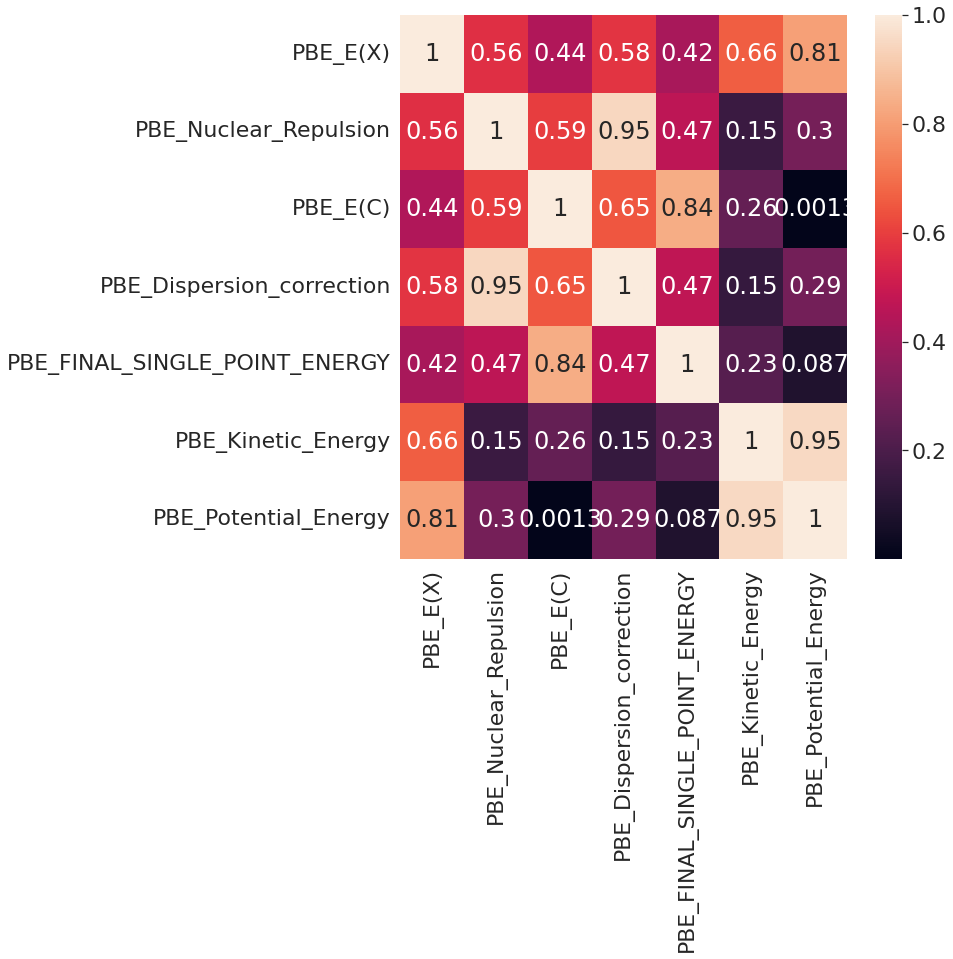

In [10]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [11]:
# search for the best model a simple grid search
#nepochs = [50, 100]
nepochs = [100]
#batch_sizes = [4, 8, 16, 32]
batch_sizes = [16, 32]
#modelshapes = [[4, 4], [8, 8], [16, 16], \
#                [32, 32], [64, 64], [128, 128], \
#                [4, 4, 4], [8, 8, 8], [16, 16, 16], \
#                [32, 32, 32], [64, 64, 64], \
#                [128, 128, 128], [4, 4, 4, 4], \
#                [8, 8, 8, 8], [16, 16, 16, 16], \
#                [32, 32, 32, 32], [64, 64, 64, 64], \
#                [128, 128, 128, 128]]
modelshapes = [[4, 4, 4], [8, 8, 8], [16, 16, 16], \
                [32, 32, 32], [64, 64, 64], \
                [128, 128, 128], [4, 4, 4, 4], \
                [8, 8, 8, 8], [16, 16, 16, 16], \
                [32, 32, 32, 32], [64, 64, 64, 64], \
                [128, 128, 128, 128], [4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8], [16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32], [64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128], [4, 4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8, 8], [16, 16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32, 32], [64, 64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128, 128]]
setname = "Full"
X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
modelminmape, modelminrmse = \
        models.nn_model(0.2, X_s, Y_s, \
                    nepochs, modelshapes, batch_sizes, inputshape=-1,\
                    search=True)
    
print("Best NN model for set: ", setname, file=sys.stderr)
print("  RMSE: ", modelminrmse, file=sys.stderr)
print("  MAPE: ", modelminmape, file=sys.stderr)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Best NN model for set:  Full
  RMSE:  ([64, 64, 64, 64, 64], 100, 16)
  MAPE:  ([64, 64, 64, 64], 100, 16)


In [12]:
import importlib
importlib.reload(models)

#build the final model and print the results
results_mape = models.nn_model(0.2, X_s, Y_s, \
                    [modelminmape[1]], \
                    [modelminmape[0]], \
                    [modelminmape[2]], \
                    inputshape=-1,\
                    search=False)

results_rmse = models.nn_model(0.2, X_s, Y_s, \
                    [modelminrmse[1]], \
                    [modelminrmse[0]], \
                    [modelminrmse[2]], \
                    inputshape=-1,\
                    search=False)

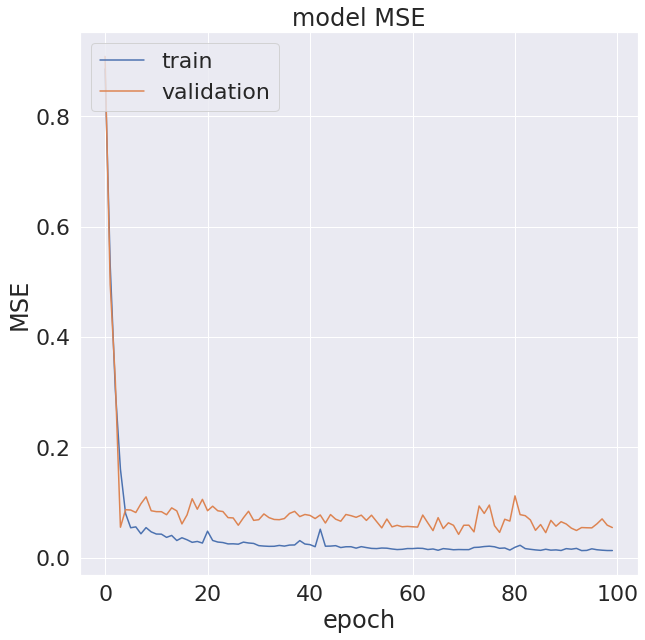

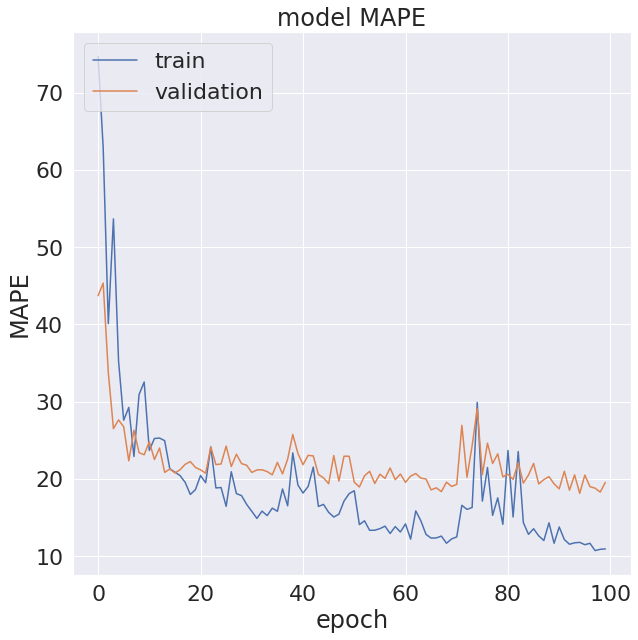

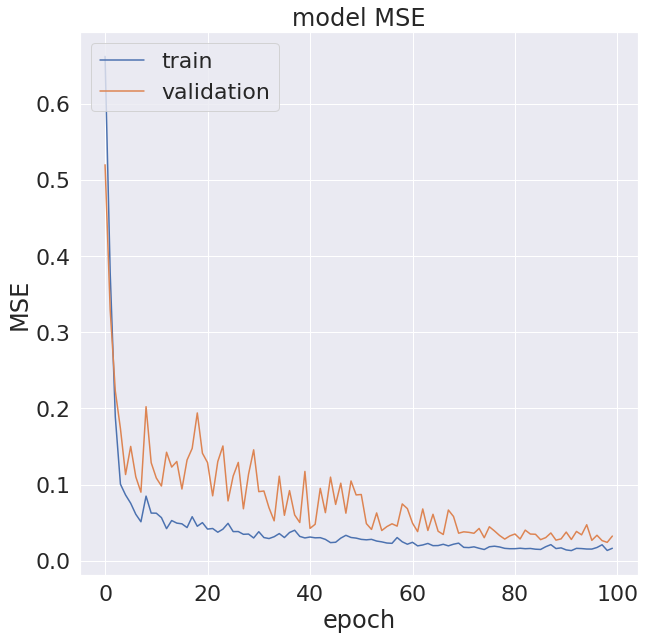

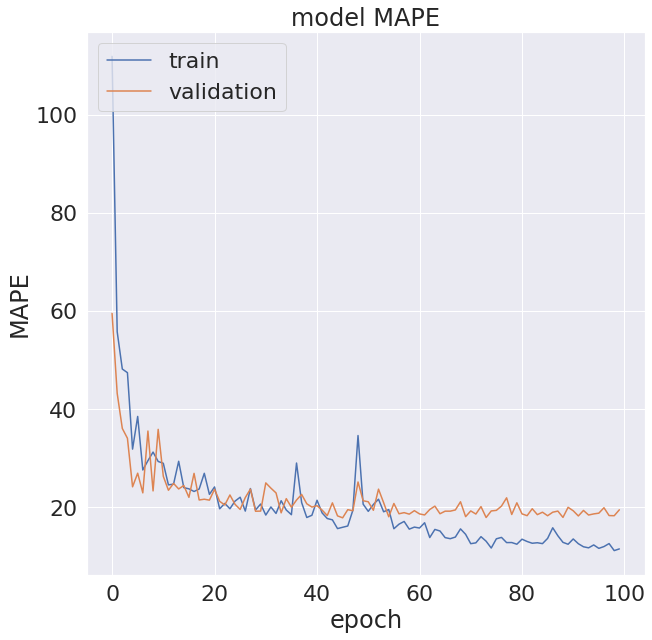

In [13]:
# summarize history for accuracy
history = results_mape['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
history = results_rmse['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


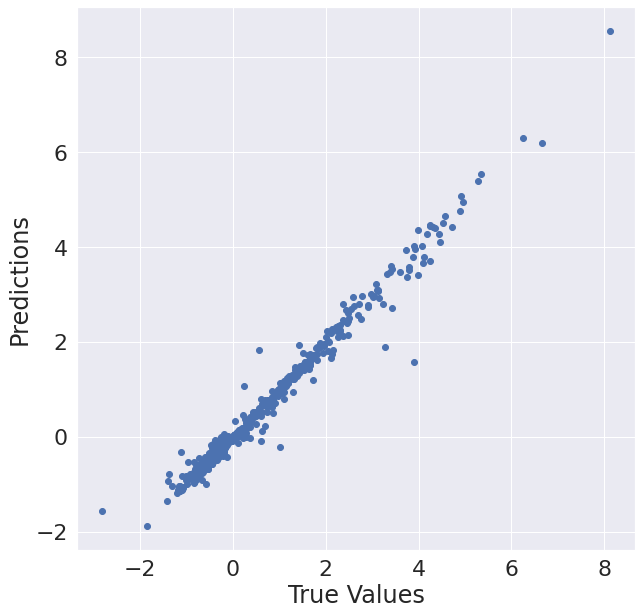

RMSE Full      : 19.69
R2 Full        :  0.98


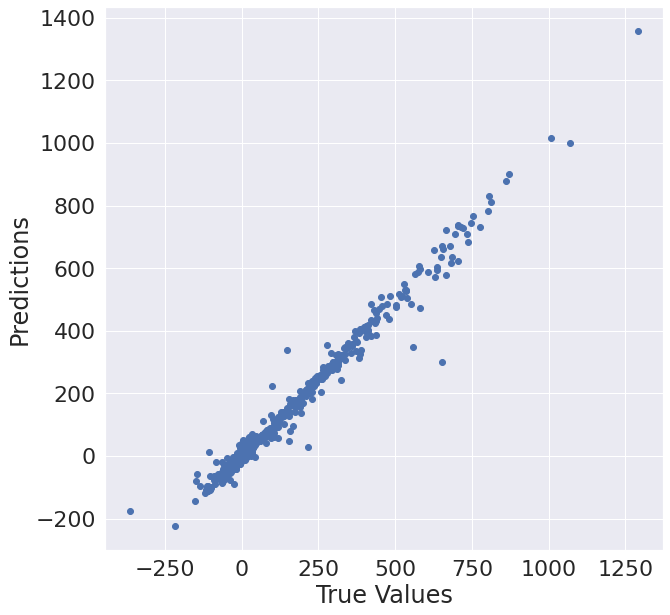

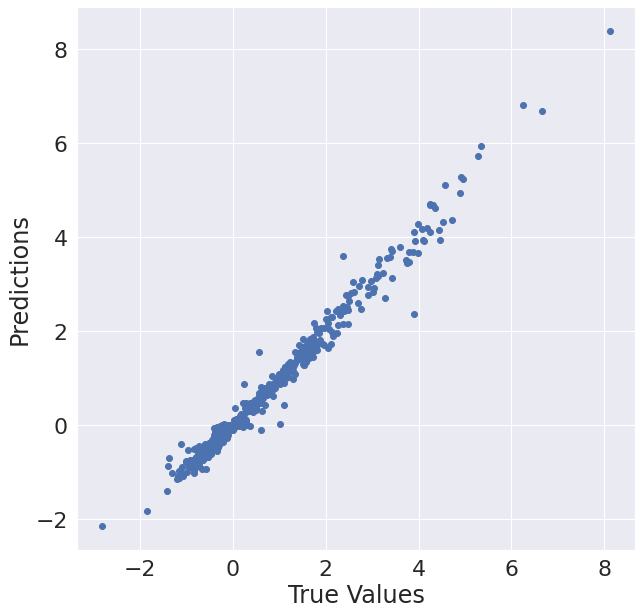

RMSE Full      : 18.26
R2 Full        :  0.99


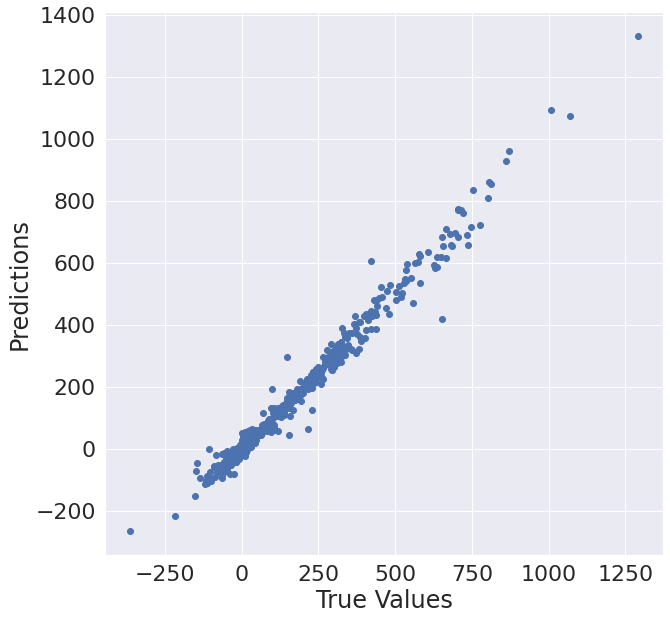

In [14]:
#denomrlize the results
plt.clf()
plt.scatter(results_mape['y_full'], \
            results_mape['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_mape['y_pred_full'])
y_full = scalery.inverse_transform(results_mape['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#denomrlize the results
plt.clf()
plt.scatter(results_rmse['y_full'], \
            results_rmse['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_rmse['y_pred_full'])
y_full = scalery.inverse_transform(results_rmse['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_percentage_error

print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred_mape = scalery.inverse_transform(results_mape['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_mape = y_pred_mape
    rmse = mean_squared_error(Y, y_pred_mape, squared=False)
    r2 = r2_score(Y, y_pred_mape)
    mape = mean_absolute_percentage_error(Y, y_pred_mape)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , MAPE, R2
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,   27.068  ,    7.697  ,    0.763  ,    0.860
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,   31.874  ,    9.378  ,    1.273  ,    0.754
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.757  ,    7.916  ,    0.263  ,    0.899
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,    7.035  ,    0.575  ,    0.506
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    2.439  ,    0.612  ,    0.768
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,    6.880  ,    0.309  ,    0.911
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   49.956  ,   10.164  ,    0.385  ,    0.485
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,   24.302  ,    3.764  ,    0.261  ,    0.974
 291 ,         

In [16]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred = scalery.inverse_transform(results_rmse['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    mape = mean_absolute_percentage_error(Y, y_pred)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE , MAPE, R2
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,   27.068  ,    8.236  ,    0.819  ,    0.839
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,   31.874  ,   10.428  ,    1.577  ,    0.696
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,   14.757  ,    9.942  ,    0.274  ,    0.841
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,   17.811  ,    7.476  ,    0.467  ,    0.442
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    2.686  ,    1.706  ,    0.307  ,    0.887
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    5.711  ,    6.447  ,    0.236  ,    0.922
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,   49.956  ,    9.281  ,    0.359  ,    0.571
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,   24.302  ,    3.793  ,    0.305  ,    0.973
 291 ,         

RMSE  BARRIER_HEIGHTS  :   8.24
MAPE  BARRIER_HEIGHTS  :   0.82
R2    BARRIER_HEIGHTS  :   0.84
RMSE MAPE BARRIER_HEIGHTS  :   7.70
MAPE MAPE BARRIER_HEIGHTS  :   0.76
R2   MAPE BARRIER_HEIGHTS  :   0.86


<Figure size 720x720 with 0 Axes>

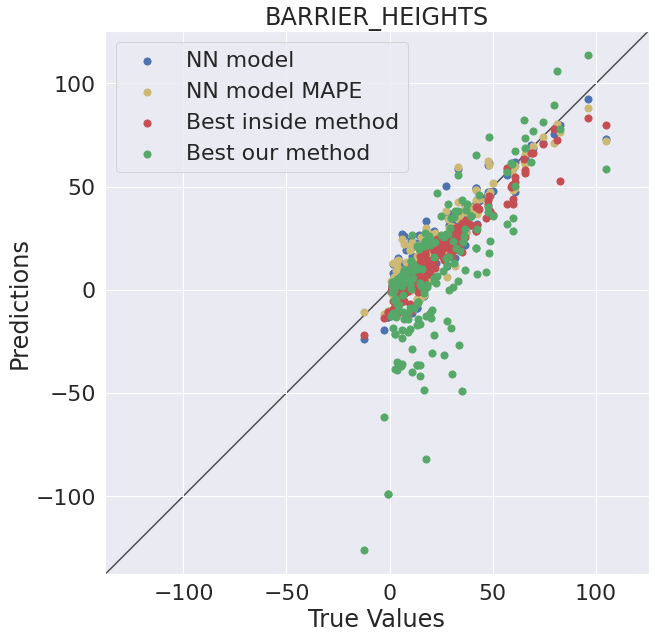

RMSE  BARRIER_HEIGHTS_BH76  :  10.43
MAPE  BARRIER_HEIGHTS_BH76  :   1.58
R2    BARRIER_HEIGHTS_BH76  :   0.70
RMSE MAPE BARRIER_HEIGHTS_BH76  :   9.38
MAPE MAPE BARRIER_HEIGHTS_BH76  :   1.27
R2   MAPE BARRIER_HEIGHTS_BH76  :   0.75


<Figure size 720x720 with 0 Axes>

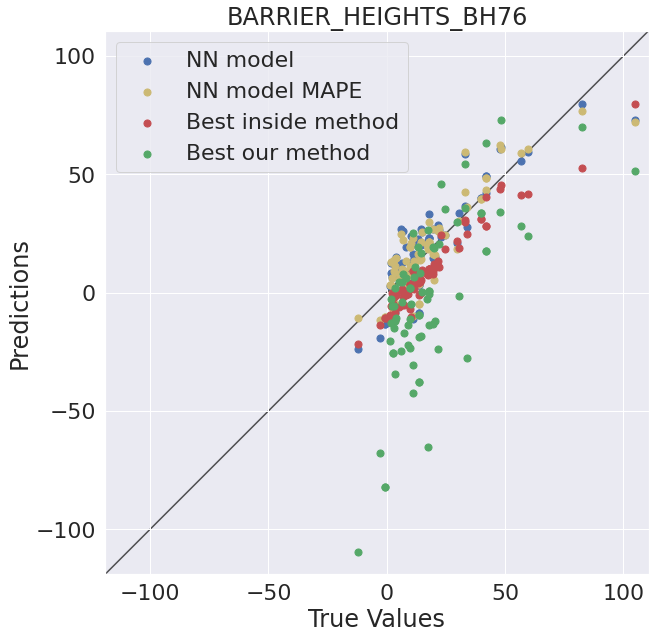

RMSE  BARRIER_HEIGHTS_BHDIV10  :   9.94
MAPE  BARRIER_HEIGHTS_BHDIV10  :   0.27
R2    BARRIER_HEIGHTS_BHDIV10  :   0.84
RMSE MAPE BARRIER_HEIGHTS_BHDIV10  :   7.92
MAPE MAPE BARRIER_HEIGHTS_BHDIV10  :   0.26
R2   MAPE BARRIER_HEIGHTS_BHDIV10  :   0.90


<Figure size 720x720 with 0 Axes>

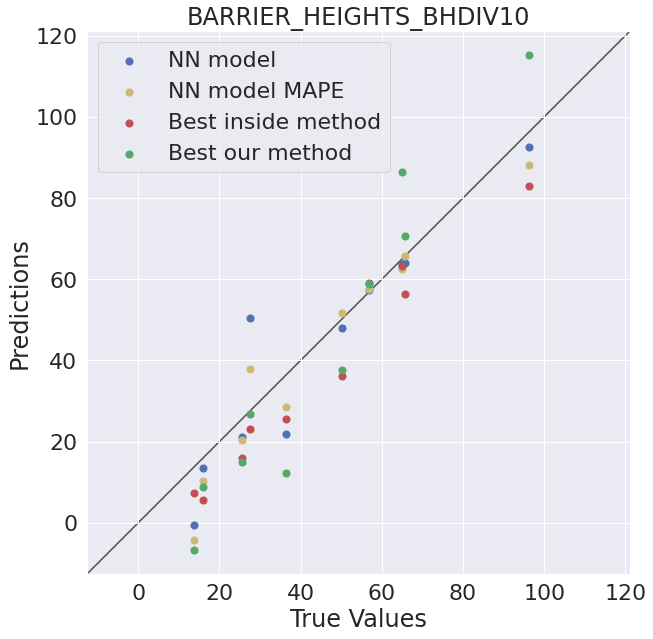

RMSE  BARRIER_HEIGHTS_BHPERI  :   7.48
MAPE  BARRIER_HEIGHTS_BHPERI  :   0.47
R2    BARRIER_HEIGHTS_BHPERI  :   0.44
RMSE MAPE BARRIER_HEIGHTS_BHPERI  :   7.04
MAPE MAPE BARRIER_HEIGHTS_BHPERI  :   0.57
R2   MAPE BARRIER_HEIGHTS_BHPERI  :   0.51


<Figure size 720x720 with 0 Axes>

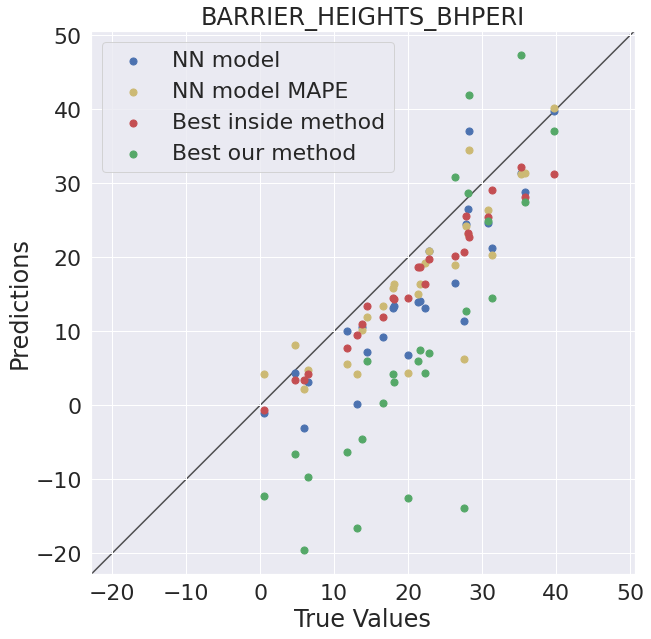

RMSE  BARRIER_HEIGHTS_BHROT27  :   1.71
MAPE  BARRIER_HEIGHTS_BHROT27  :   0.31
R2    BARRIER_HEIGHTS_BHROT27  :   0.89
RMSE MAPE BARRIER_HEIGHTS_BHROT27  :   2.44
MAPE MAPE BARRIER_HEIGHTS_BHROT27  :   0.61
R2   MAPE BARRIER_HEIGHTS_BHROT27  :   0.77


<Figure size 720x720 with 0 Axes>

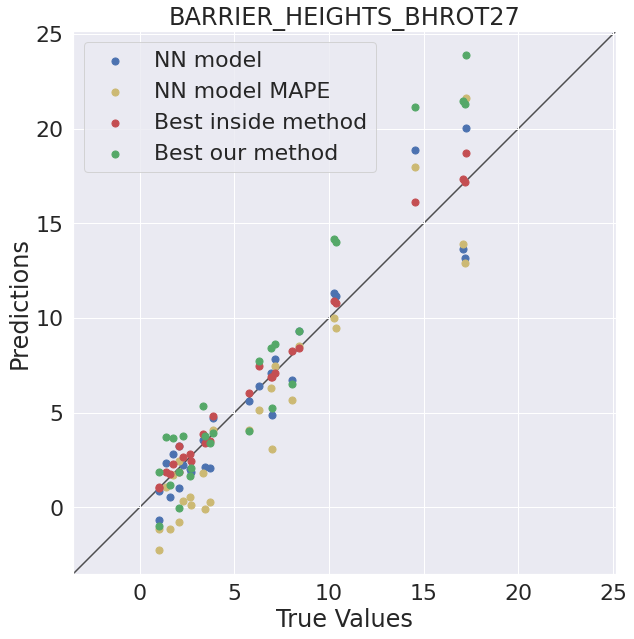

RMSE  BARRIER_HEIGHTS_INV24  :   6.45
MAPE  BARRIER_HEIGHTS_INV24  :   0.24
R2    BARRIER_HEIGHTS_INV24  :   0.92
RMSE MAPE BARRIER_HEIGHTS_INV24  :   6.88
MAPE MAPE BARRIER_HEIGHTS_INV24  :   0.31
R2   MAPE BARRIER_HEIGHTS_INV24  :   0.91


<Figure size 720x720 with 0 Axes>

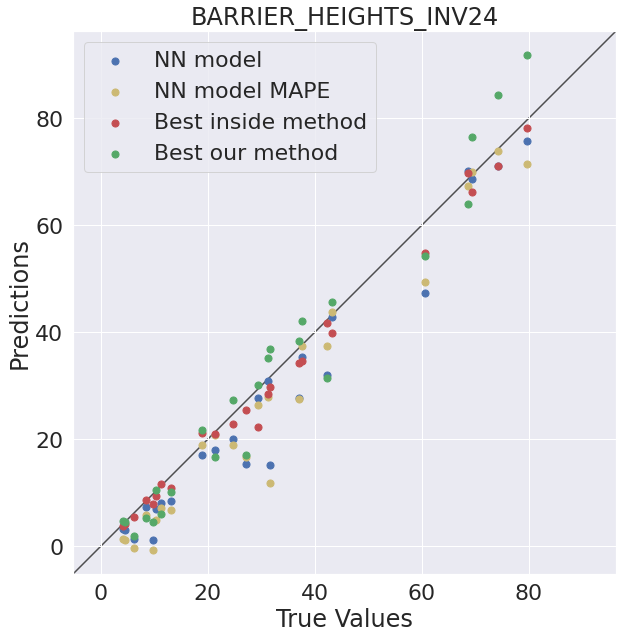

RMSE  BARRIER_HEIGHTS_PX13  :   9.28
MAPE  BARRIER_HEIGHTS_PX13  :   0.36
R2    BARRIER_HEIGHTS_PX13  :   0.57
RMSE MAPE BARRIER_HEIGHTS_PX13  :  10.16
MAPE MAPE BARRIER_HEIGHTS_PX13  :   0.38
R2   MAPE BARRIER_HEIGHTS_PX13  :   0.49


<Figure size 720x720 with 0 Axes>

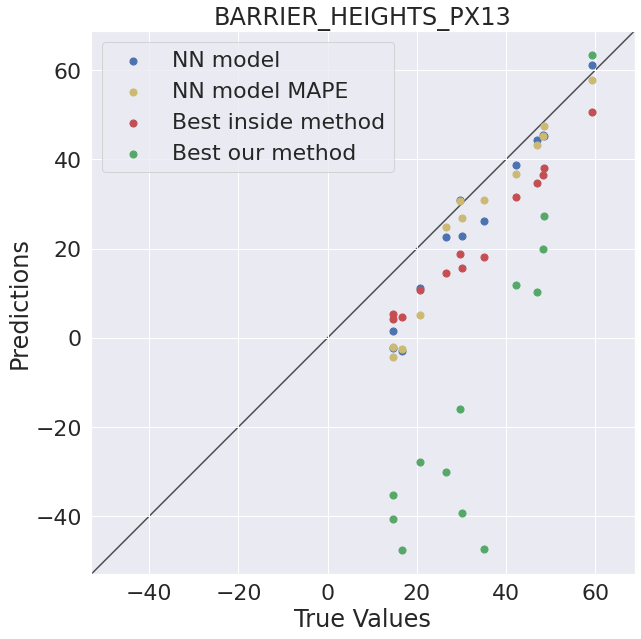

RMSE  BARRIER_HEIGHTS_WCPT18  :   3.79
MAPE  BARRIER_HEIGHTS_WCPT18  :   0.31
R2    BARRIER_HEIGHTS_WCPT18  :   0.97
RMSE MAPE BARRIER_HEIGHTS_WCPT18  :   3.76
MAPE MAPE BARRIER_HEIGHTS_WCPT18  :   0.26
R2   MAPE BARRIER_HEIGHTS_WCPT18  :   0.97


<Figure size 720x720 with 0 Axes>

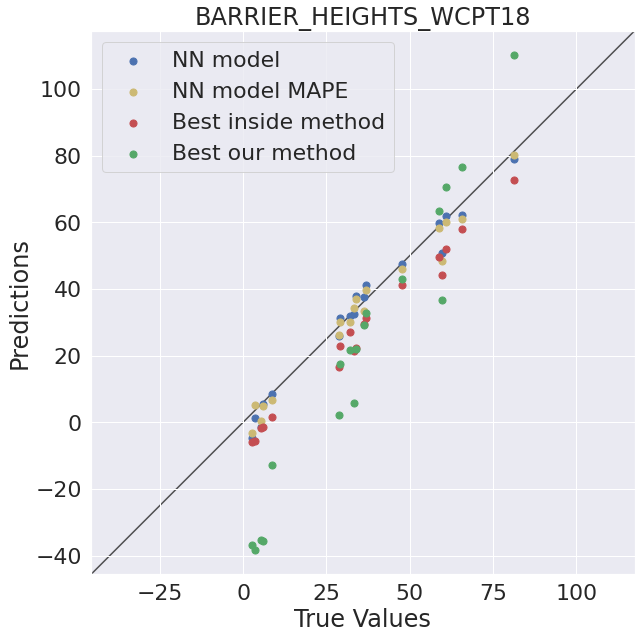

RMSE  INTRAMOLECULAR_INTERACTIONS  :   2.95
MAPE  INTRAMOLECULAR_INTERACTIONS  :   1.12
R2    INTRAMOLECULAR_INTERACTIONS  :   0.56
RMSE MAPE INTRAMOLECULAR_INTERACTIONS  :   2.60
MAPE MAPE INTRAMOLECULAR_INTERACTIONS  :   1.60
R2   MAPE INTRAMOLECULAR_INTERACTIONS  :   0.66


<Figure size 720x720 with 0 Axes>

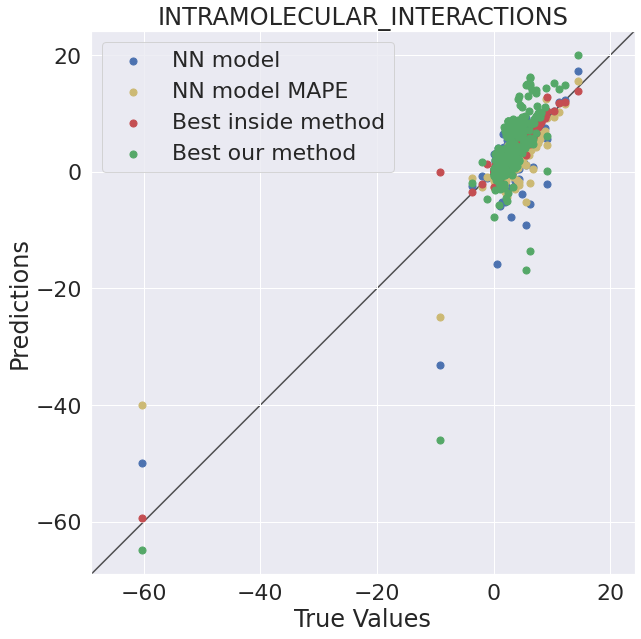

RMSE  INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.17
MAPE  INTRAMOLECULAR_INTERACTIONS_ACONF  :   0.35
R2    INTRAMOLECULAR_INTERACTIONS_ACONF  :   0.15
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.33
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :   1.13
R2   MAPE INTRAMOLECULAR_INTERACTIONS_ACONF  :  -0.09


<Figure size 720x720 with 0 Axes>

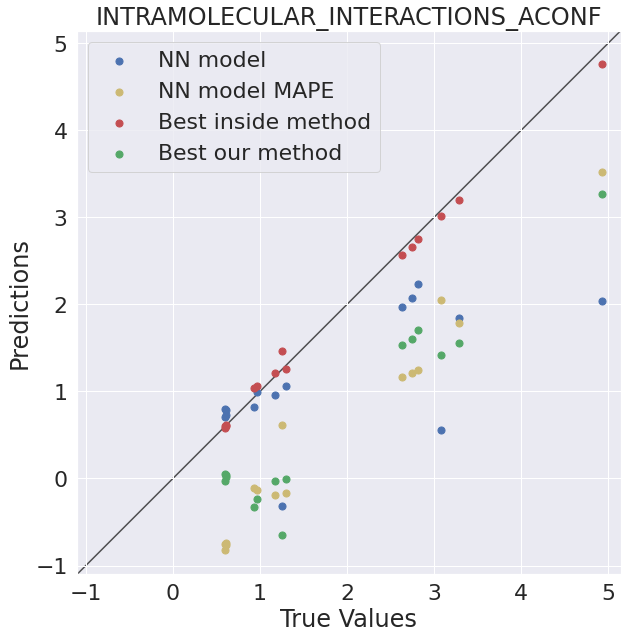

RMSE  INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   1.33
MAPE  INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   0.84
R2    INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   0.40
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   1.98
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_Amino20x4  :   2.09
R2   MAPE INTRAMOLECULAR_INTERACTIONS_Amino20x4  :  -0.34


<Figure size 720x720 with 0 Axes>

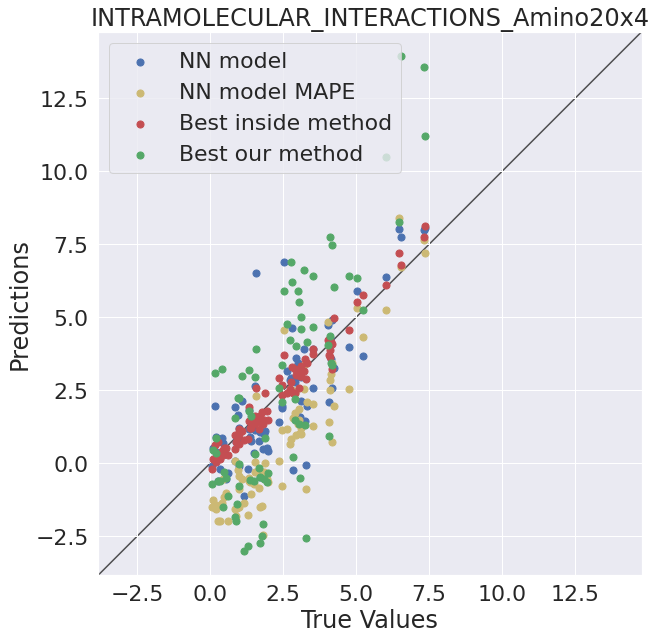

RMSE  INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   1.51
MAPE  INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   0.61
R2    INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :  -2.58
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   0.86
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :   0.44
R2   MAPE INTRAMOLECULAR_INTERACTIONS_BUT14DIOL  :  -0.15


<Figure size 720x720 with 0 Axes>

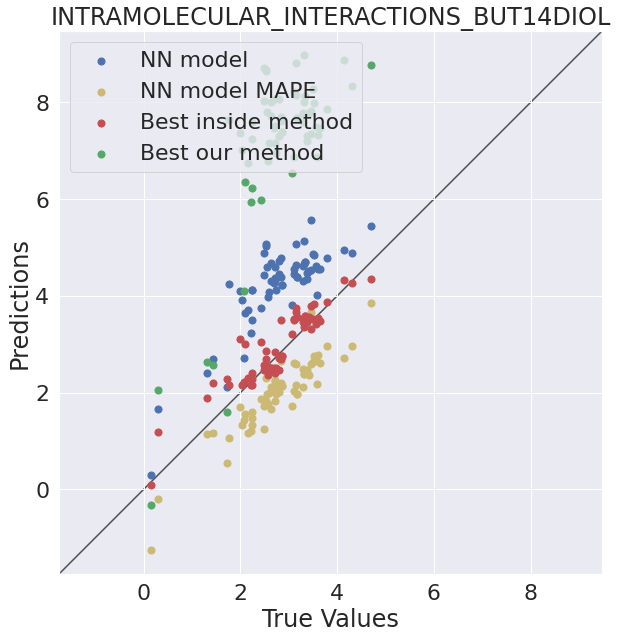

RMSE  INTRAMOLECULAR_INTERACTIONS_ICONF  :   2.65
MAPE  INTRAMOLECULAR_INTERACTIONS_ICONF  :   2.17
R2    INTRAMOLECULAR_INTERACTIONS_ICONF  :   0.29
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :   3.35
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :   2.05
R2   MAPE INTRAMOLECULAR_INTERACTIONS_ICONF  :  -0.12


<Figure size 720x720 with 0 Axes>

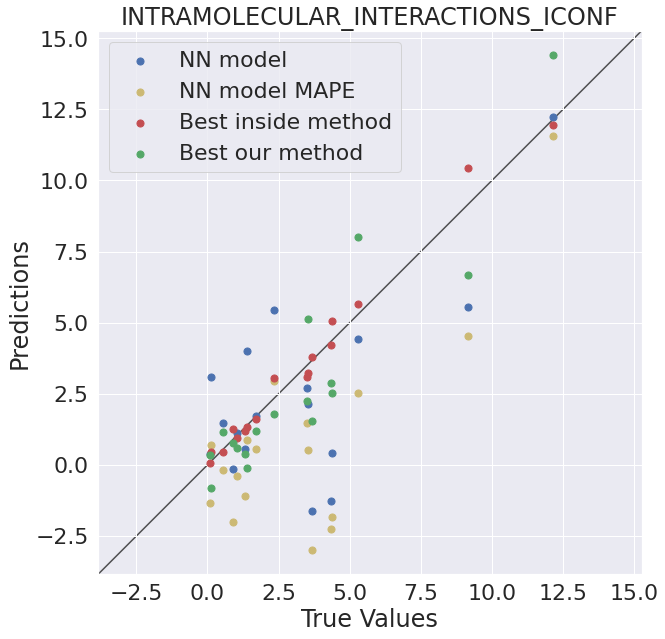

RMSE  INTRAMOLECULAR_INTERACTIONS_IDISP  :  11.63
MAPE  INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.86
R2    INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.74
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :  10.53
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.56
R2   MAPE INTRAMOLECULAR_INTERACTIONS_IDISP  :   0.78


<Figure size 720x720 with 0 Axes>

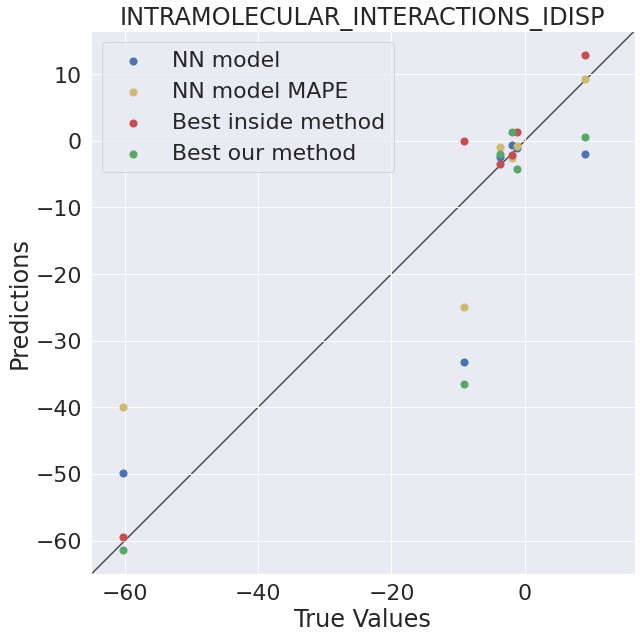

RMSE  INTRAMOLECULAR_INTERACTIONS_MCONF  :   1.06
MAPE  INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.36
R2    INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.72
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   1.73
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.39
R2   MAPE INTRAMOLECULAR_INTERACTIONS_MCONF  :   0.25


<Figure size 720x720 with 0 Axes>

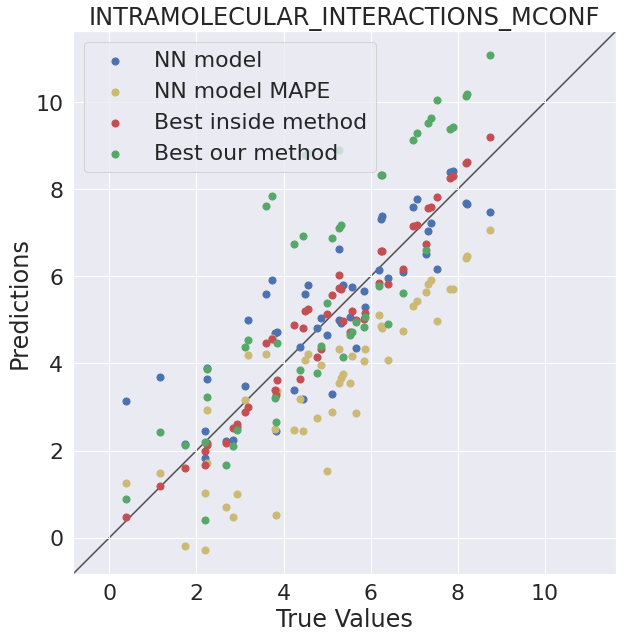

RMSE  INTRAMOLECULAR_INTERACTIONS_PCONF21  :   3.27
MAPE  INTRAMOLECULAR_INTERACTIONS_PCONF21  :   5.11
R2    INTRAMOLECULAR_INTERACTIONS_PCONF21  : -17.80
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :   2.39
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :   8.47
R2   MAPE INTRAMOLECULAR_INTERACTIONS_PCONF21  :  -9.01


<Figure size 720x720 with 0 Axes>

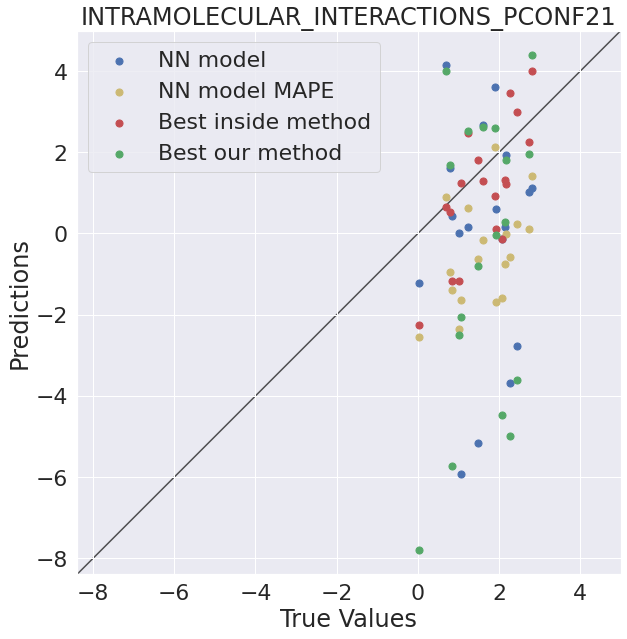

RMSE  INTRAMOLECULAR_INTERACTIONS_SCONF  :   4.67
MAPE  INTRAMOLECULAR_INTERACTIONS_SCONF  :   0.94
R2    INTRAMOLECULAR_INTERACTIONS_SCONF  :  -5.29
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :   3.65
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :   1.49
R2   MAPE INTRAMOLECULAR_INTERACTIONS_SCONF  :  -2.84


<Figure size 720x720 with 0 Axes>

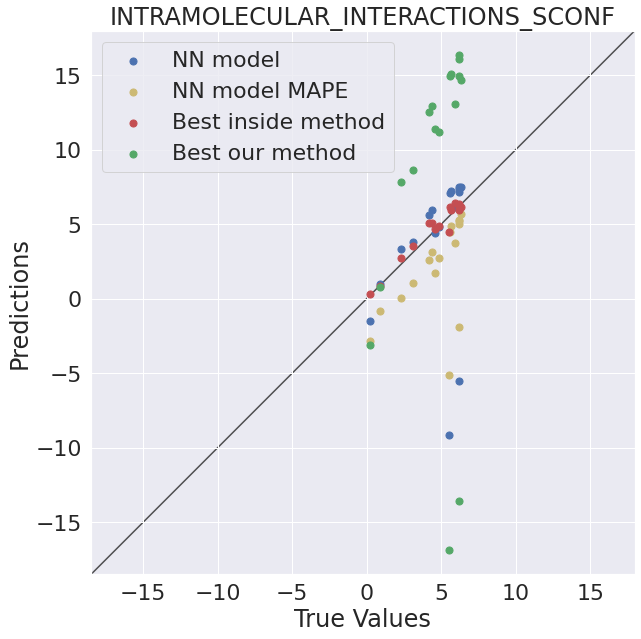

RMSE  INTRAMOLECULAR_INTERACTIONS_UPU23  :   5.39
MAPE  INTRAMOLECULAR_INTERACTIONS_UPU23  :   2.06
R2    INTRAMOLECULAR_INTERACTIONS_UPU23  :  -1.99
RMSE MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :   3.29
MAPE MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :   0.69
R2   MAPE INTRAMOLECULAR_INTERACTIONS_UPU23  :  -0.11


<Figure size 720x720 with 0 Axes>

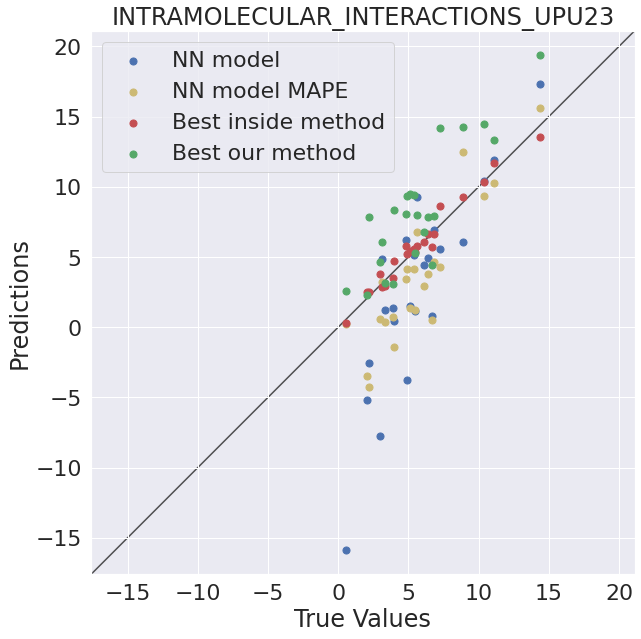

RMSE  SMALL_MOLECULES  :  22.20
MAPE  SMALL_MOLECULES  :   1.19
R2    SMALL_MOLECULES  :   0.99
RMSE MAPE SMALL_MOLECULES  :  19.44
MAPE MAPE SMALL_MOLECULES  :   1.19
R2   MAPE SMALL_MOLECULES  :   0.99


<Figure size 720x720 with 0 Axes>

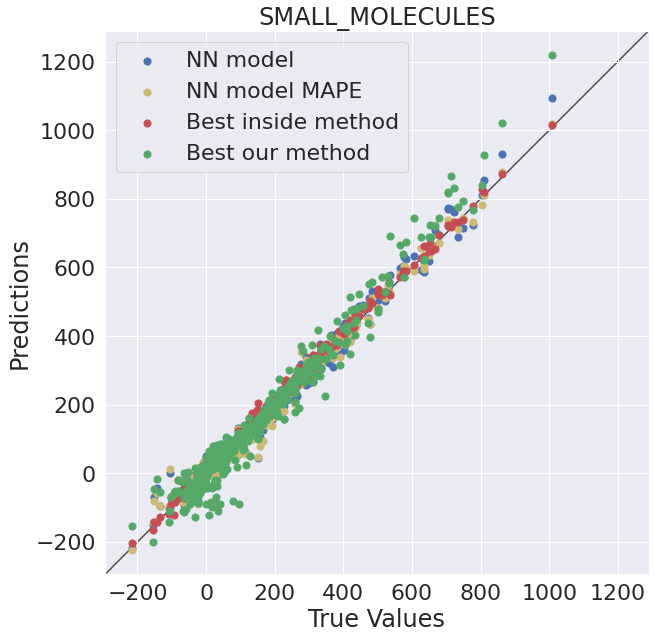

RMSE  SMALL_MOLECULES_AL2X6  :  11.24
MAPE  SMALL_MOLECULES_AL2X6  :   0.27
R2    SMALL_MOLECULES_AL2X6  :  -0.66
RMSE MAPE SMALL_MOLECULES_AL2X6  :   1.85
MAPE MAPE SMALL_MOLECULES_AL2X6  :   0.04
R2   MAPE SMALL_MOLECULES_AL2X6  :   0.96


<Figure size 720x720 with 0 Axes>

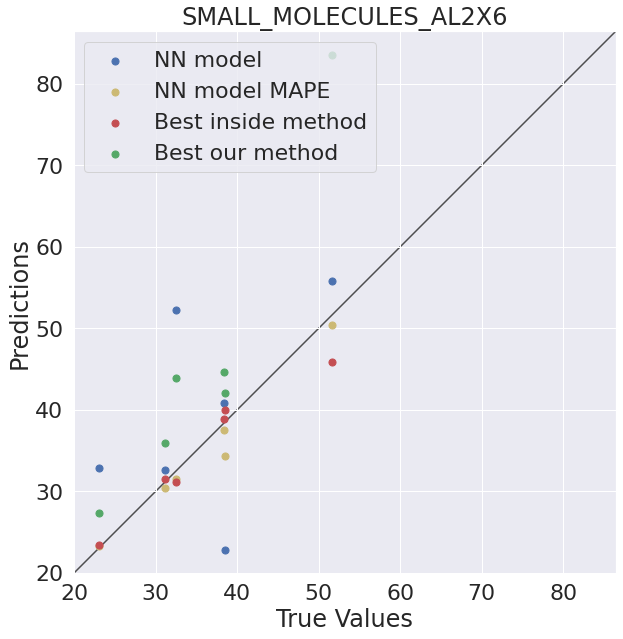

RMSE  SMALL_MOLECULES_ALK8  :   4.06
MAPE  SMALL_MOLECULES_ALK8  :   0.04
R2    SMALL_MOLECULES_ALK8  :   0.98
RMSE MAPE SMALL_MOLECULES_ALK8  :   2.72
MAPE MAPE SMALL_MOLECULES_ALK8  :   0.04
R2   MAPE SMALL_MOLECULES_ALK8  :   0.99


<Figure size 720x720 with 0 Axes>

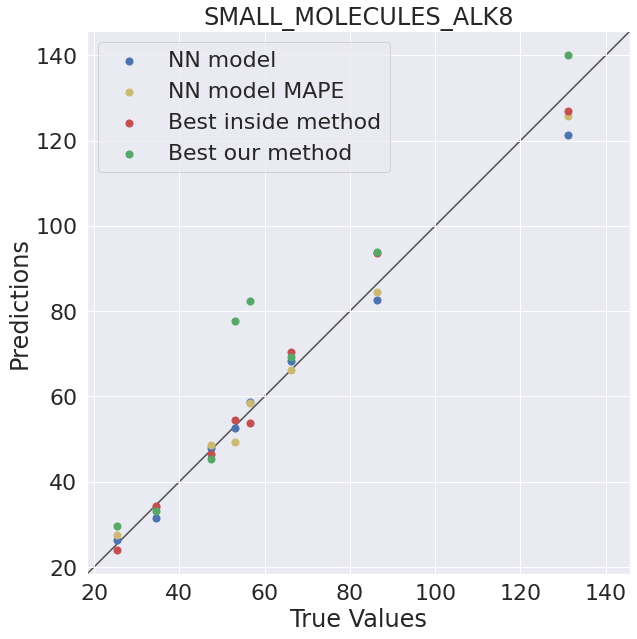

RMSE  SMALL_MOLECULES_ALKBDE10  :  25.88
MAPE  SMALL_MOLECULES_ALKBDE10  :   0.17
R2    SMALL_MOLECULES_ALKBDE10  :   0.33
RMSE MAPE SMALL_MOLECULES_ALKBDE10  :  24.34
MAPE MAPE SMALL_MOLECULES_ALKBDE10  :   0.13
R2   MAPE SMALL_MOLECULES_ALKBDE10  :   0.41


<Figure size 720x720 with 0 Axes>

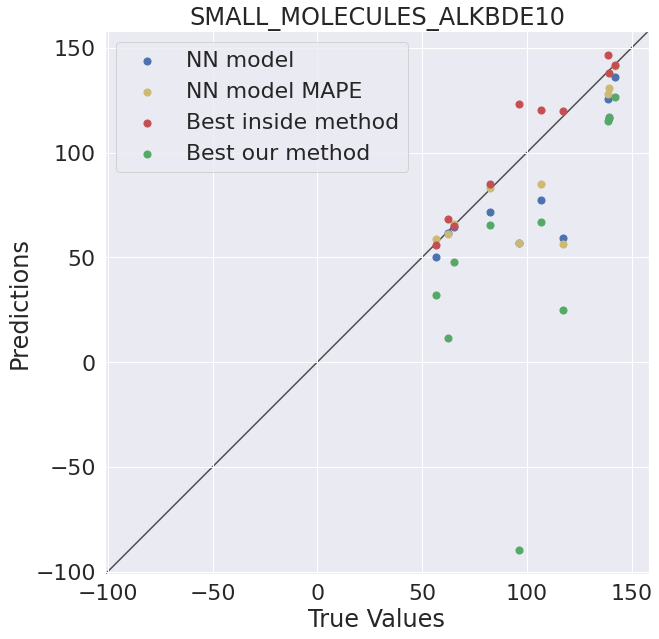

RMSE  SMALL_MOLECULES_BH76RC  :  11.20
MAPE  SMALL_MOLECULES_BH76RC  :   1.65
R2    SMALL_MOLECULES_BH76RC  :   0.74
RMSE MAPE SMALL_MOLECULES_BH76RC  :  12.16
MAPE MAPE SMALL_MOLECULES_BH76RC  :   1.17
R2   MAPE SMALL_MOLECULES_BH76RC  :   0.70


<Figure size 720x720 with 0 Axes>

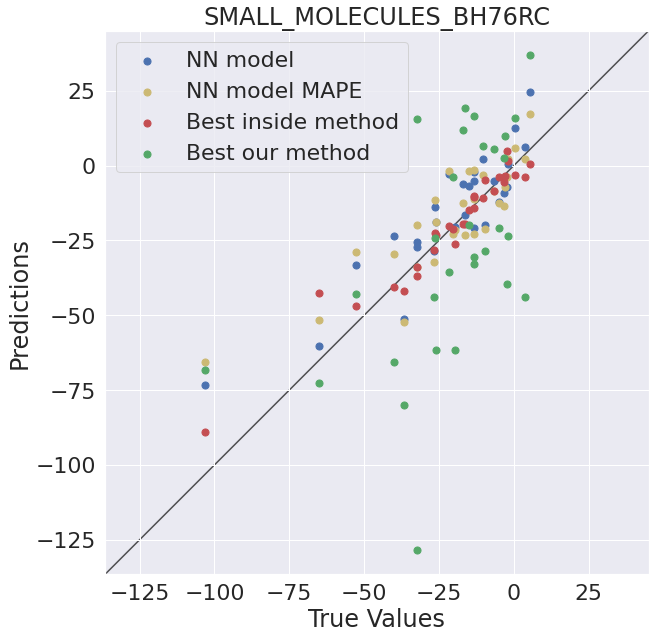

RMSE  SMALL_MOLECULES_DC13  :  44.29
MAPE  SMALL_MOLECULES_DC13  :   0.55
R2    SMALL_MOLECULES_DC13  :   0.60
RMSE MAPE SMALL_MOLECULES_DC13  :  46.82
MAPE MAPE SMALL_MOLECULES_DC13  :   0.81
R2   MAPE SMALL_MOLECULES_DC13  :   0.55


<Figure size 720x720 with 0 Axes>

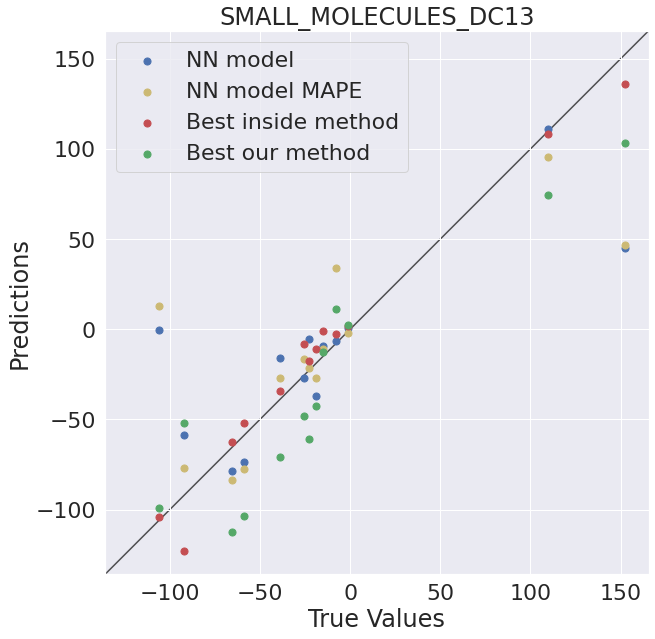

RMSE  SMALL_MOLECULES_DIPCS10  :  35.33
MAPE  SMALL_MOLECULES_DIPCS10  :   0.05
R2    SMALL_MOLECULES_DIPCS10  :   0.81
RMSE MAPE SMALL_MOLECULES_DIPCS10  :  29.63
MAPE MAPE SMALL_MOLECULES_DIPCS10  :   0.04
R2   MAPE SMALL_MOLECULES_DIPCS10  :   0.86


<Figure size 720x720 with 0 Axes>

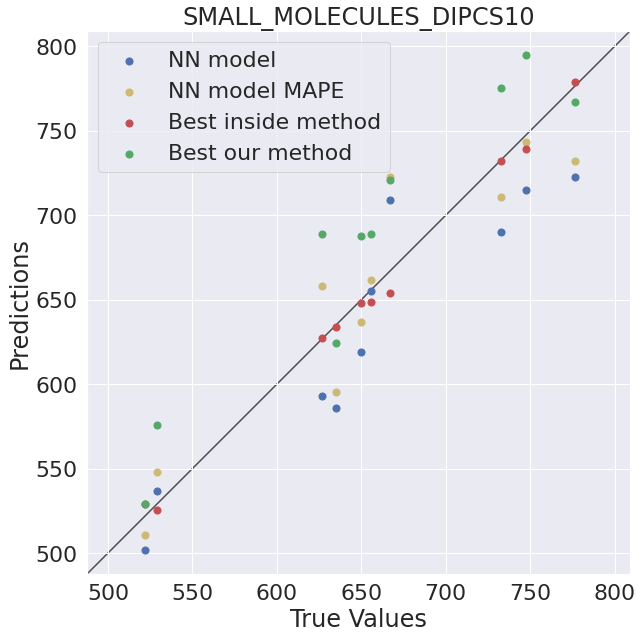

RMSE  SMALL_MOLECULES_FH51  :  24.98
MAPE  SMALL_MOLECULES_FH51  :   1.61
R2    SMALL_MOLECULES_FH51  :   0.43
RMSE MAPE SMALL_MOLECULES_FH51  :  22.47
MAPE MAPE SMALL_MOLECULES_FH51  :   2.18
R2   MAPE SMALL_MOLECULES_FH51  :   0.54


<Figure size 720x720 with 0 Axes>

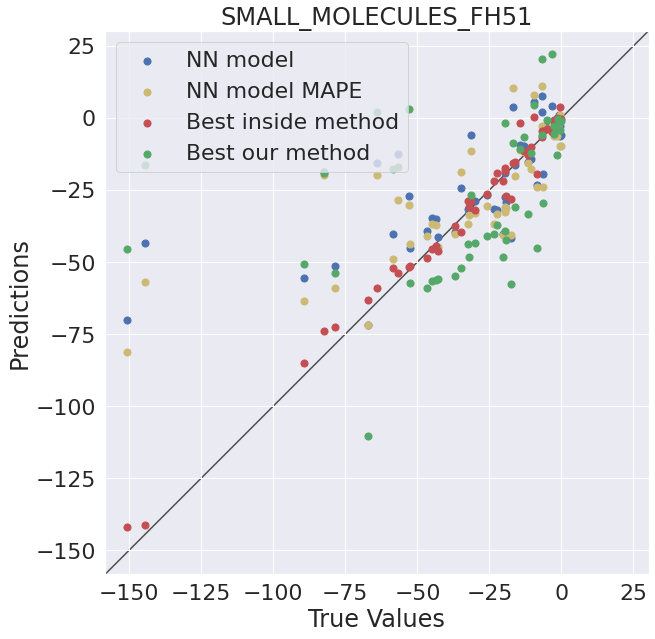

RMSE  SMALL_MOLECULES_G21EA  :  20.76
MAPE  SMALL_MOLECULES_G21EA  :  10.96
R2    SMALL_MOLECULES_G21EA  :   0.20
RMSE MAPE SMALL_MOLECULES_G21EA  :  20.59
MAPE MAPE SMALL_MOLECULES_G21EA  :   9.21
R2   MAPE SMALL_MOLECULES_G21EA  :   0.22


<Figure size 720x720 with 0 Axes>

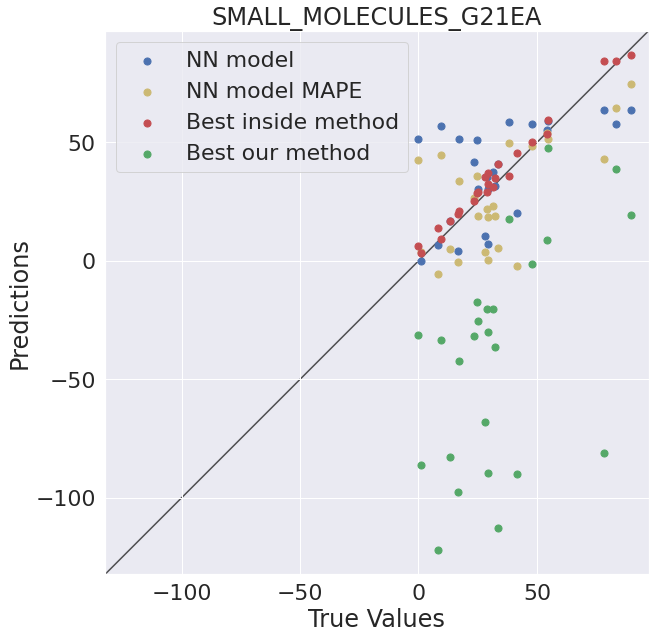

RMSE  SMALL_MOLECULES_G21IP  :  25.31
MAPE  SMALL_MOLECULES_G21IP  :   0.08
R2    SMALL_MOLECULES_G21IP  :   0.84
RMSE MAPE SMALL_MOLECULES_G21IP  :  16.23
MAPE MAPE SMALL_MOLECULES_G21IP  :   0.04
R2   MAPE SMALL_MOLECULES_G21IP  :   0.93


<Figure size 720x720 with 0 Axes>

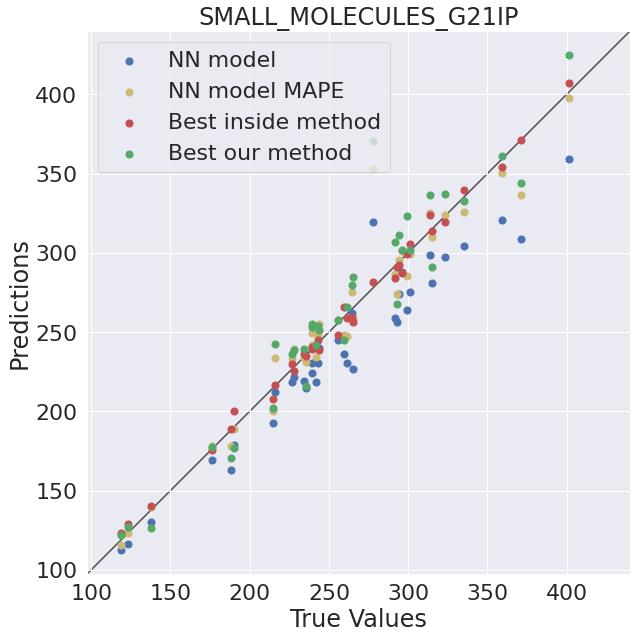

RMSE  SMALL_MOLECULES_G2RC  :  21.44
MAPE  SMALL_MOLECULES_G2RC  :   1.00
R2    SMALL_MOLECULES_G2RC  :   0.83
RMSE MAPE SMALL_MOLECULES_G2RC  :  23.02
MAPE MAPE SMALL_MOLECULES_G2RC  :   1.43
R2   MAPE SMALL_MOLECULES_G2RC  :   0.80


<Figure size 720x720 with 0 Axes>

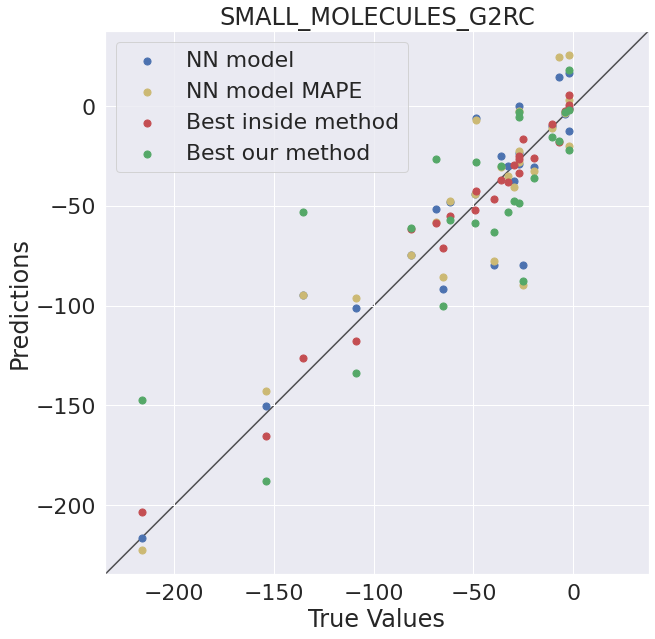

RMSE  SMALL_MOLECULES_HEAVYSB11  :   6.39
MAPE  SMALL_MOLECULES_HEAVYSB11  :   0.09
R2    SMALL_MOLECULES_HEAVYSB11  :   0.35
RMSE MAPE SMALL_MOLECULES_HEAVYSB11  :   6.36
MAPE MAPE SMALL_MOLECULES_HEAVYSB11  :   0.08
R2   MAPE SMALL_MOLECULES_HEAVYSB11  :   0.35


<Figure size 720x720 with 0 Axes>

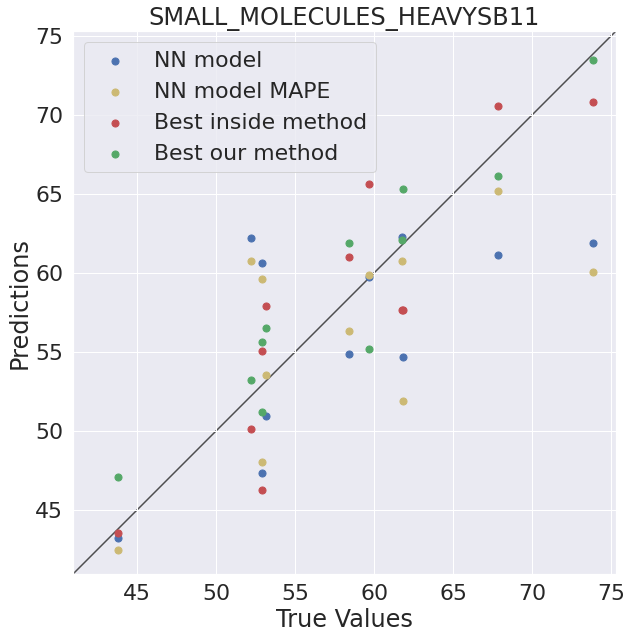

RMSE  SMALL_MOLECULES_NBPRC  :   9.24
MAPE  SMALL_MOLECULES_NBPRC  :   0.81
R2    SMALL_MOLECULES_NBPRC  :   0.90
RMSE MAPE SMALL_MOLECULES_NBPRC  :   8.35
MAPE MAPE SMALL_MOLECULES_NBPRC  :   1.78
R2   MAPE SMALL_MOLECULES_NBPRC  :   0.92


<Figure size 720x720 with 0 Axes>

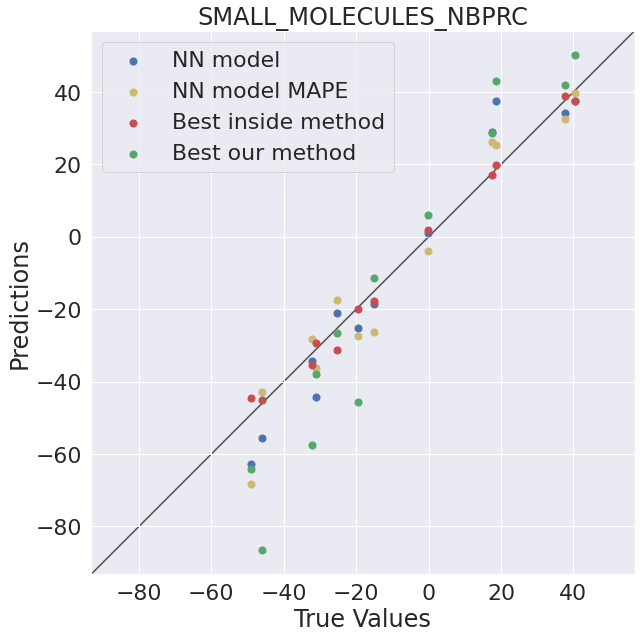

RMSE  SMALL_MOLECULES_PA26  :  19.89
MAPE  SMALL_MOLECULES_PA26  :   0.09
R2    SMALL_MOLECULES_PA26  :   0.62
RMSE MAPE SMALL_MOLECULES_PA26  :  30.85
MAPE MAPE SMALL_MOLECULES_PA26  :   0.14
R2   MAPE SMALL_MOLECULES_PA26  :   0.09


<Figure size 720x720 with 0 Axes>

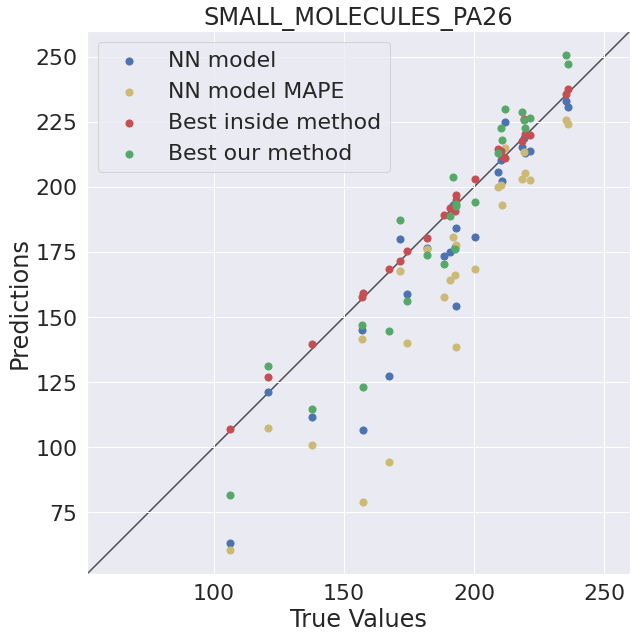

RMSE  SMALL_MOLECULES_RC21  :  12.26
MAPE  SMALL_MOLECULES_RC21  :   2.19
R2    SMALL_MOLECULES_RC21  :   0.79
RMSE MAPE SMALL_MOLECULES_RC21  :  13.75
MAPE MAPE SMALL_MOLECULES_RC21  :   2.25
R2   MAPE SMALL_MOLECULES_RC21  :   0.73


<Figure size 720x720 with 0 Axes>

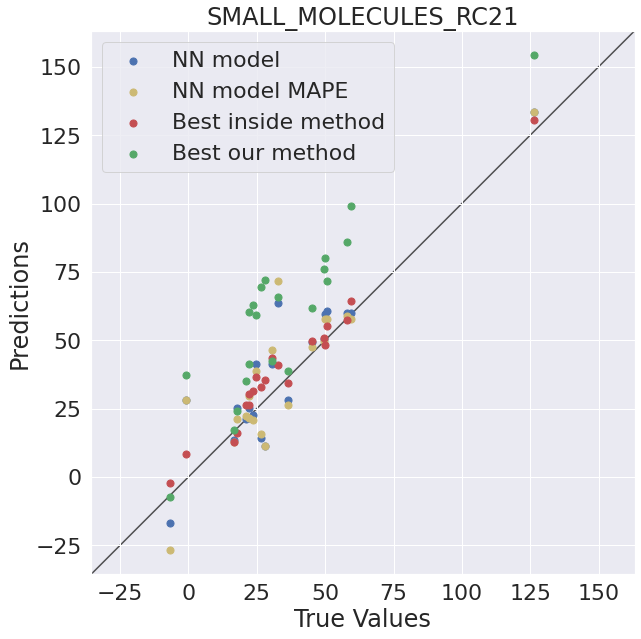

RMSE  SMALL_MOLECULES_SIE4x4  :  15.31
MAPE  SMALL_MOLECULES_SIE4x4  :   0.69
R2    SMALL_MOLECULES_SIE4x4  :   0.25
RMSE MAPE SMALL_MOLECULES_SIE4x4  :  13.45
MAPE MAPE SMALL_MOLECULES_SIE4x4  :   0.56
R2   MAPE SMALL_MOLECULES_SIE4x4  :   0.42


<Figure size 720x720 with 0 Axes>

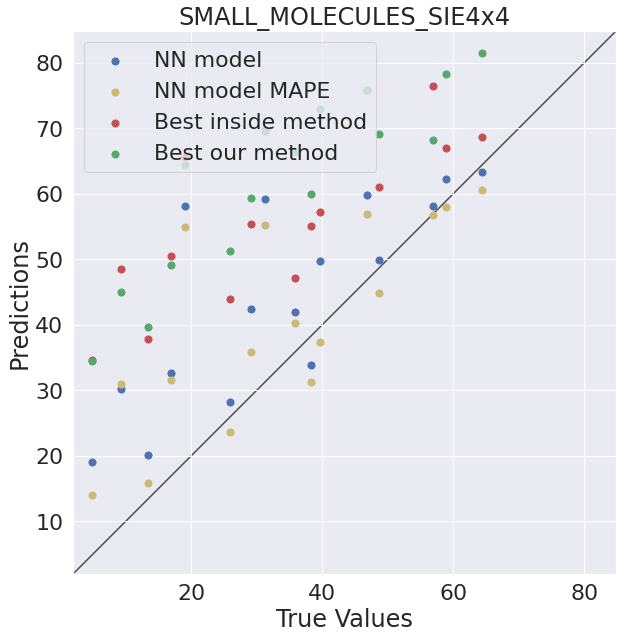

RMSE  SMALL_MOLECULES_TAUT15  :   6.54
MAPE  SMALL_MOLECULES_TAUT15  :   2.40
R2    SMALL_MOLECULES_TAUT15  :  -1.68
RMSE MAPE SMALL_MOLECULES_TAUT15  :   8.12
MAPE MAPE SMALL_MOLECULES_TAUT15  :   3.08
R2   MAPE SMALL_MOLECULES_TAUT15  :  -3.14


<Figure size 720x720 with 0 Axes>

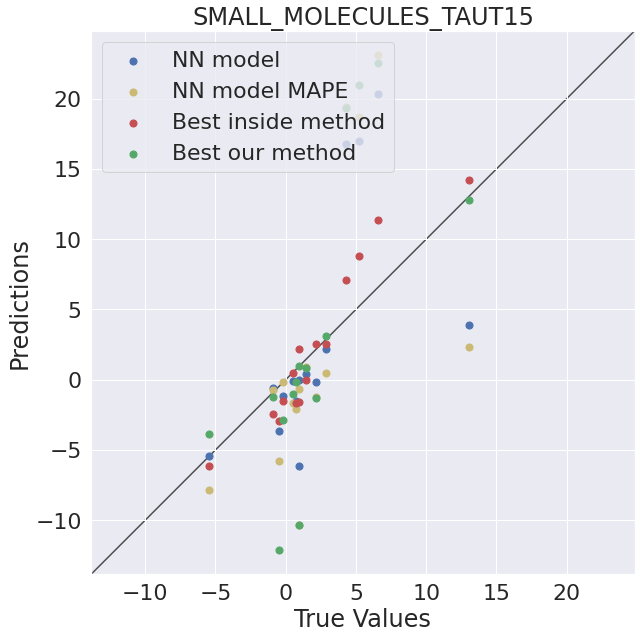

RMSE  SMALL_MOLECULES_W4-11  :  24.88
MAPE  SMALL_MOLECULES_W4-11  :   0.07
R2    SMALL_MOLECULES_W4-11  :   0.98
RMSE MAPE SMALL_MOLECULES_W4-11  :  16.44
MAPE MAPE SMALL_MOLECULES_W4-11  :   0.05
R2   MAPE SMALL_MOLECULES_W4-11  :   0.99


<Figure size 720x720 with 0 Axes>

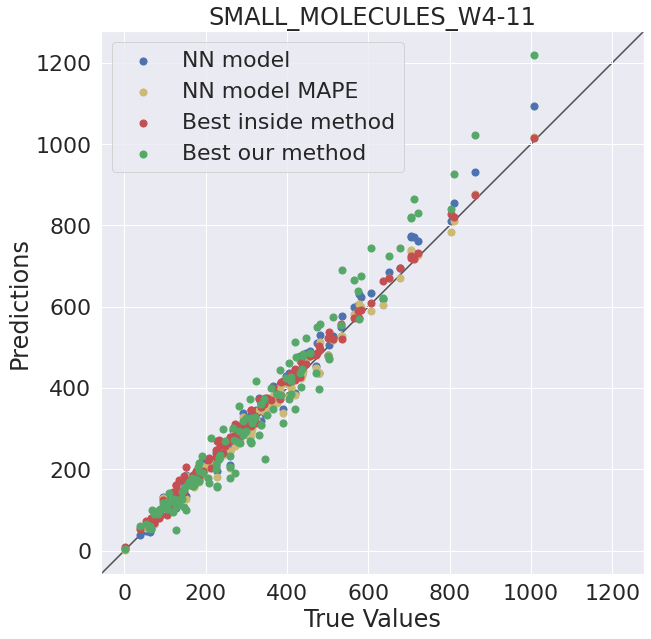

RMSE  SMALL_MOLECULES_YBDE18  :   5.83
MAPE  SMALL_MOLECULES_YBDE18  :   0.09
R2    SMALL_MOLECULES_YBDE18  :   0.91
RMSE MAPE SMALL_MOLECULES_YBDE18  :   4.16
MAPE MAPE SMALL_MOLECULES_YBDE18  :   0.07
R2   MAPE SMALL_MOLECULES_YBDE18  :   0.96


<Figure size 720x720 with 0 Axes>

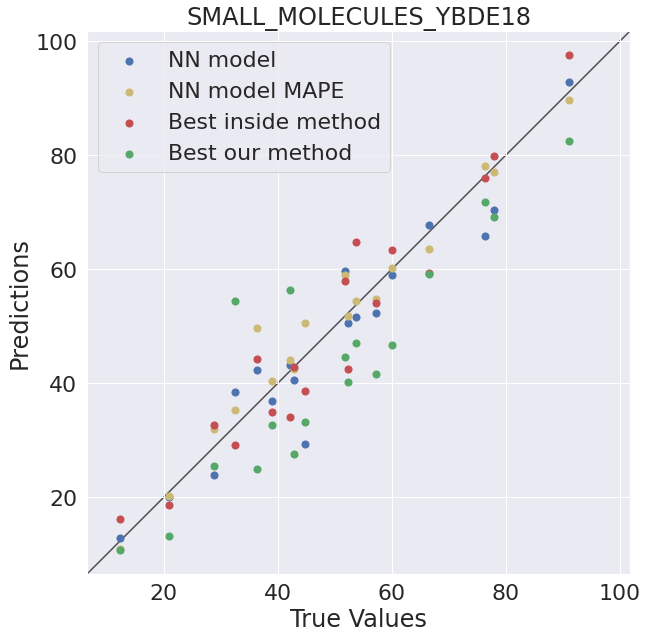

RMSE  INTERMOLECULAR_INTERACTIONS  :   5.43
MAPE  INTERMOLECULAR_INTERACTIONS  :   0.68
R2    INTERMOLECULAR_INTERACTIONS  :   0.98
RMSE MAPE INTERMOLECULAR_INTERACTIONS  :   5.25
MAPE MAPE INTERMOLECULAR_INTERACTIONS  :   0.76
R2   MAPE INTERMOLECULAR_INTERACTIONS  :   0.98


<Figure size 720x720 with 0 Axes>

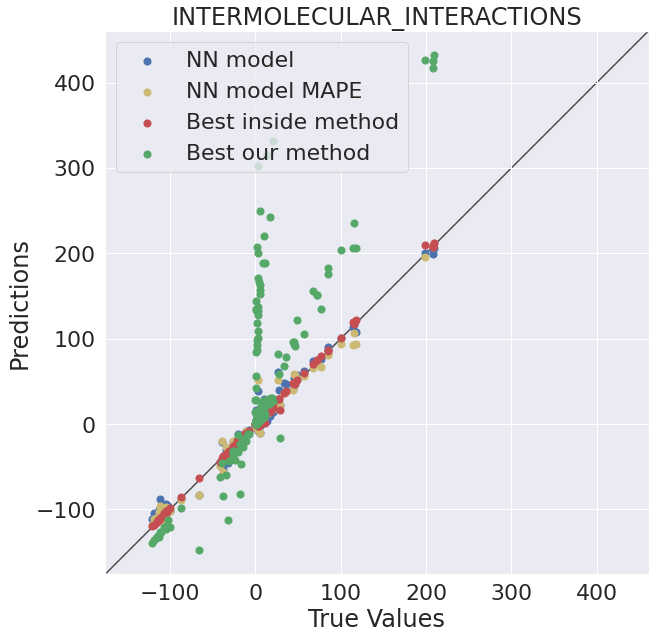

RMSE  INTERMOLECULAR_INTERACTIONS_ADIM6  :   1.14
MAPE  INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.46
R2    INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.38
RMSE MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :   1.33
MAPE MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.39
R2   MAPE INTERMOLECULAR_INTERACTIONS_ADIM6  :   0.16


<Figure size 720x720 with 0 Axes>

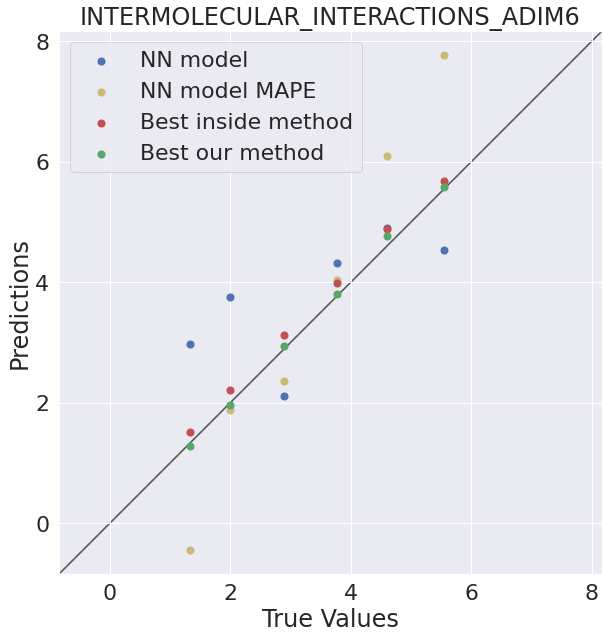

RMSE  INTERMOLECULAR_INTERACTIONS_AHB21  :   6.59
MAPE  INTERMOLECULAR_INTERACTIONS_AHB21  :   0.18
R2    INTERMOLECULAR_INTERACTIONS_AHB21  :   0.76
RMSE MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   7.25
MAPE MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   0.24
R2   MAPE INTERMOLECULAR_INTERACTIONS_AHB21  :   0.71


<Figure size 720x720 with 0 Axes>

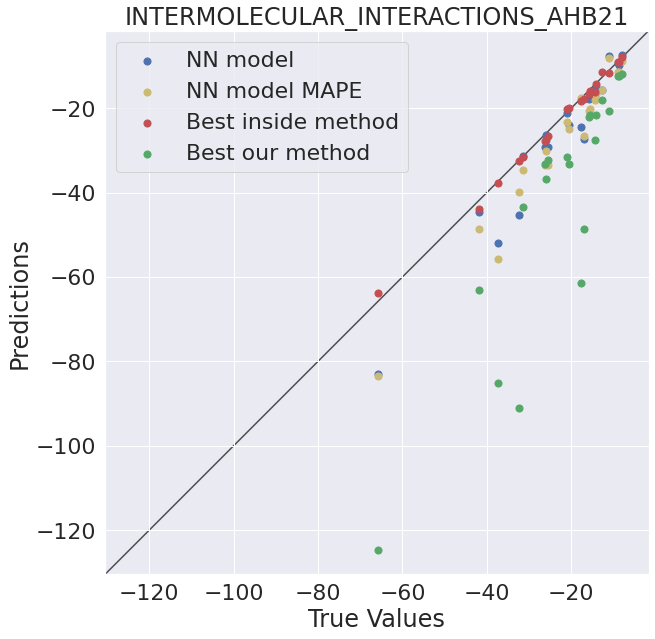

RMSE  INTERMOLECULAR_INTERACTIONS_CARBHB12  :   2.57
MAPE  INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.24
R2    INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.63
RMSE MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   2.08
MAPE MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.46
R2   MAPE INTERMOLECULAR_INTERACTIONS_CARBHB12  :   0.76


<Figure size 720x720 with 0 Axes>

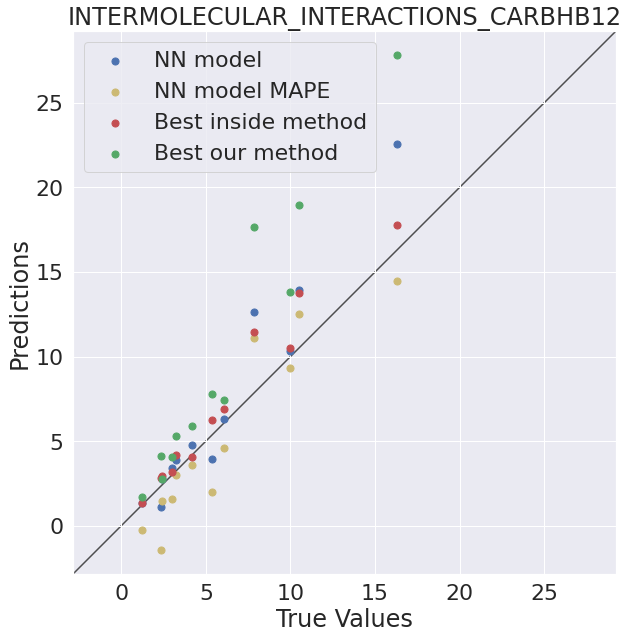

RMSE  INTERMOLECULAR_INTERACTIONS_CHB6  :   8.58
MAPE  INTERMOLECULAR_INTERACTIONS_CHB6  :   0.21
R2    INTERMOLECULAR_INTERACTIONS_CHB6  :  -0.27
RMSE MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :   9.14
MAPE MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :   0.22
R2   MAPE INTERMOLECULAR_INTERACTIONS_CHB6  :  -0.44


<Figure size 720x720 with 0 Axes>

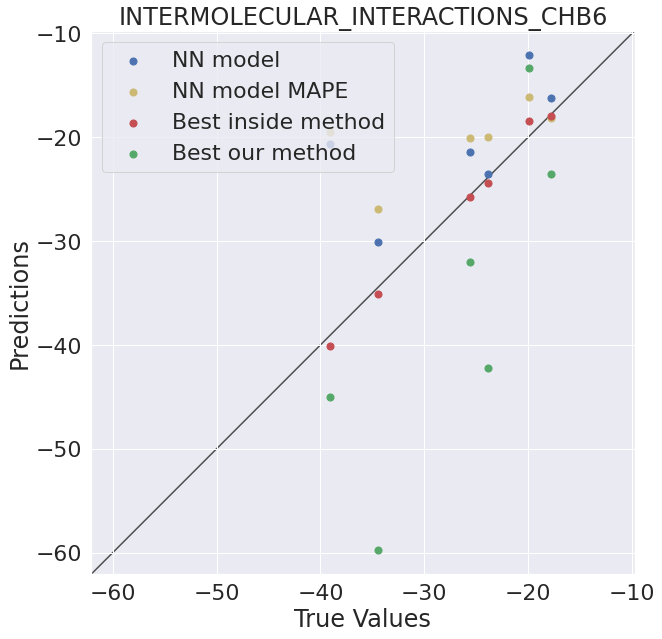

RMSE  INTERMOLECULAR_INTERACTIONS_HAL59  :   7.46
MAPE  INTERMOLECULAR_INTERACTIONS_HAL59  :   1.98
R2    INTERMOLECULAR_INTERACTIONS_HAL59  :  -2.13
RMSE MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :   7.66
MAPE MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :   1.54
R2   MAPE INTERMOLECULAR_INTERACTIONS_HAL59  :  -2.30


<Figure size 720x720 with 0 Axes>

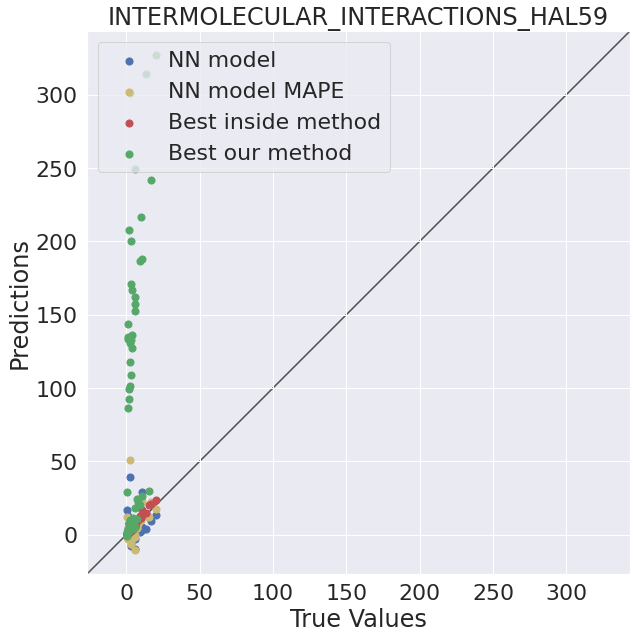

RMSE  INTERMOLECULAR_INTERACTIONS_HEAVY28  :   0.99
MAPE  INTERMOLECULAR_INTERACTIONS_HEAVY28  :   0.67
R2    INTERMOLECULAR_INTERACTIONS_HEAVY28  :  -0.94
RMSE MAPE INTERMOLECULAR_INTERACTIONS_HEAVY28  :   0.92
MAPE MAPE INTERMOLECULAR_INTERACTIONS_HEAVY28  :   0.76
R2   MAPE INTERMOLECULAR_INTERACTIONS_HEAVY28  :  -0.69


<Figure size 720x720 with 0 Axes>

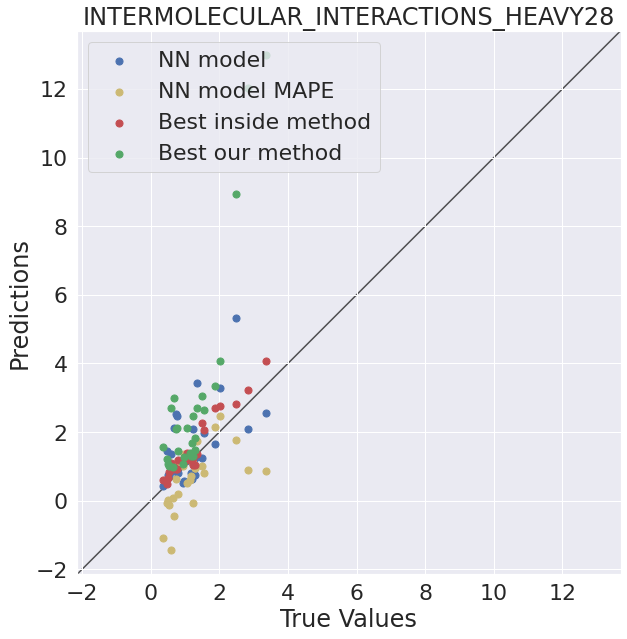

RMSE  INTERMOLECULAR_INTERACTIONS_IL16  :  10.05
MAPE  INTERMOLECULAR_INTERACTIONS_IL16  :   0.07
R2    INTERMOLECULAR_INTERACTIONS_IL16  :  -0.55
RMSE MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   6.06
MAPE MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   0.04
R2   MAPE INTERMOLECULAR_INTERACTIONS_IL16  :   0.43


<Figure size 720x720 with 0 Axes>

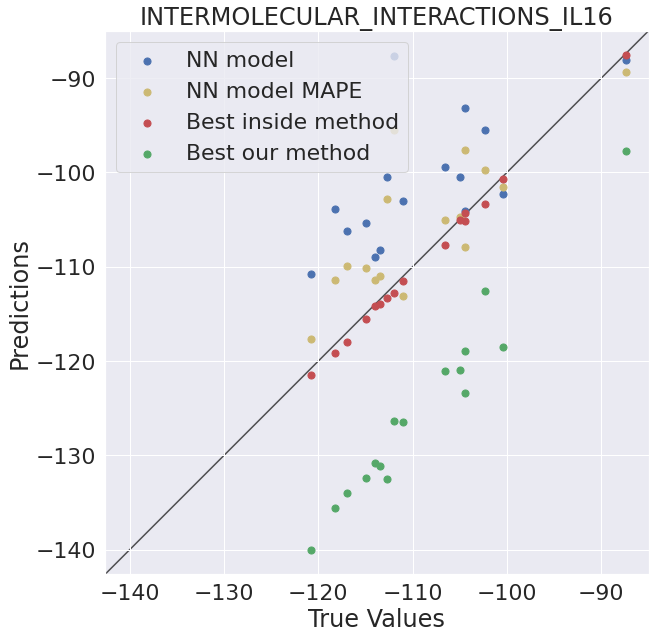

RMSE  INTERMOLECULAR_INTERACTIONS_PNICO23  :   2.33
MAPE  INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.40
R2    INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.22
RMSE MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   2.20
MAPE MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.41
R2   MAPE INTERMOLECULAR_INTERACTIONS_PNICO23  :   0.31


<Figure size 720x720 with 0 Axes>

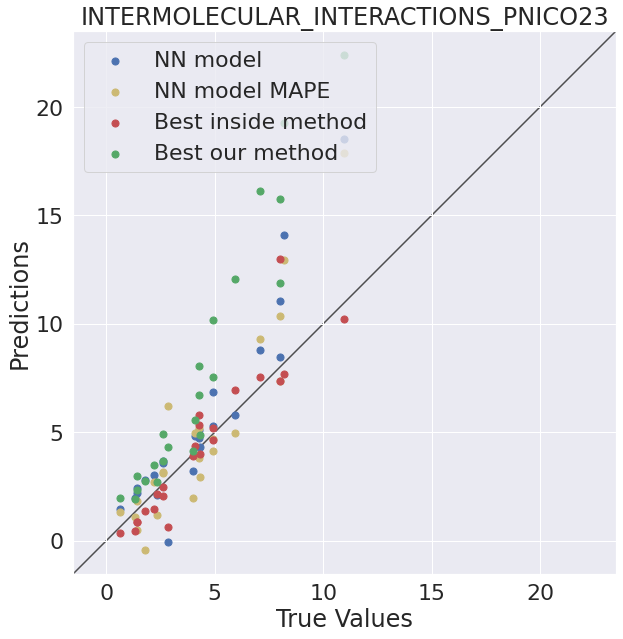

RMSE  INTERMOLECULAR_INTERACTIONS_RG18  :   1.46
MAPE  INTERMOLECULAR_INTERACTIONS_RG18  :   1.41
R2    INTERMOLECULAR_INTERACTIONS_RG18  : -12.28
RMSE MAPE INTERMOLECULAR_INTERACTIONS_RG18  :   1.35
MAPE MAPE INTERMOLECULAR_INTERACTIONS_RG18  :   4.10
R2   MAPE INTERMOLECULAR_INTERACTIONS_RG18  : -10.32


<Figure size 720x720 with 0 Axes>

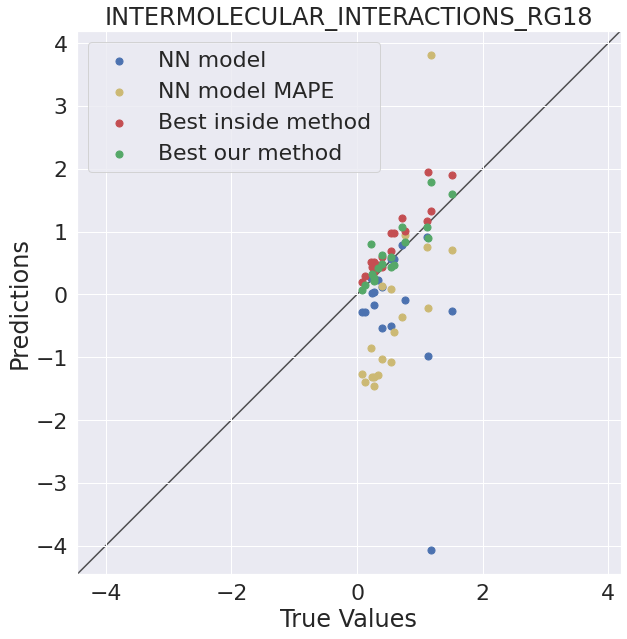

RMSE  INTERMOLECULAR_INTERACTIONS_S22  :   1.59
MAPE  INTERMOLECULAR_INTERACTIONS_S22  :   0.32
R2    INTERMOLECULAR_INTERACTIONS_S22  :   0.94
RMSE MAPE INTERMOLECULAR_INTERACTIONS_S22  :   1.82
MAPE MAPE INTERMOLECULAR_INTERACTIONS_S22  :   0.43
R2   MAPE INTERMOLECULAR_INTERACTIONS_S22  :   0.92


<Figure size 720x720 with 0 Axes>

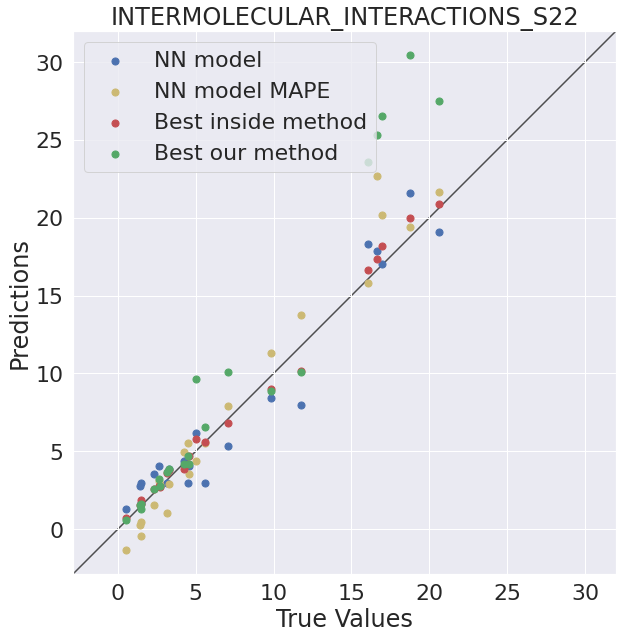

RMSE  INTERMOLECULAR_INTERACTIONS_S66  :   1.06
MAPE  INTERMOLECULAR_INTERACTIONS_S66  :   0.21
R2    INTERMOLECULAR_INTERACTIONS_S66  :   0.93
RMSE MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.73
MAPE MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.14
R2   MAPE INTERMOLECULAR_INTERACTIONS_S66  :   0.97


<Figure size 720x720 with 0 Axes>

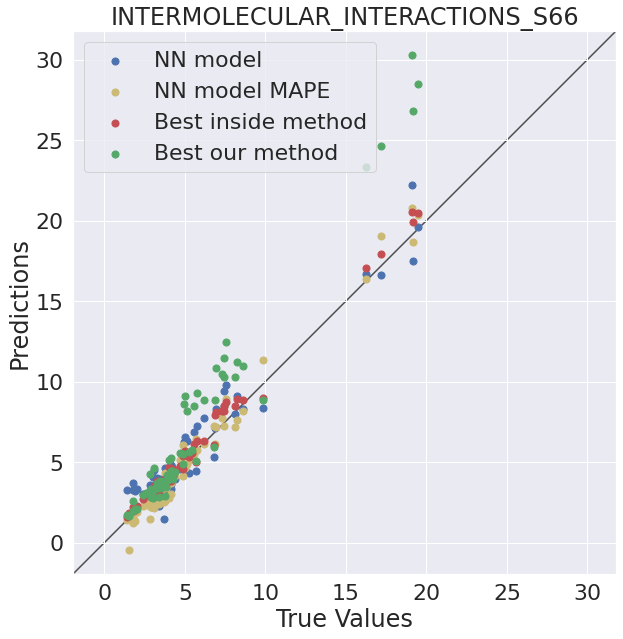

RMSE  INTERMOLECULAR_INTERACTIONS_WATER27  :   9.21
MAPE  INTERMOLECULAR_INTERACTIONS_WATER27  :   0.16
R2    INTERMOLECULAR_INTERACTIONS_WATER27  :   0.98
RMSE MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :   9.39
MAPE MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :   0.12
R2   MAPE INTERMOLECULAR_INTERACTIONS_WATER27  :   0.98


<Figure size 720x720 with 0 Axes>

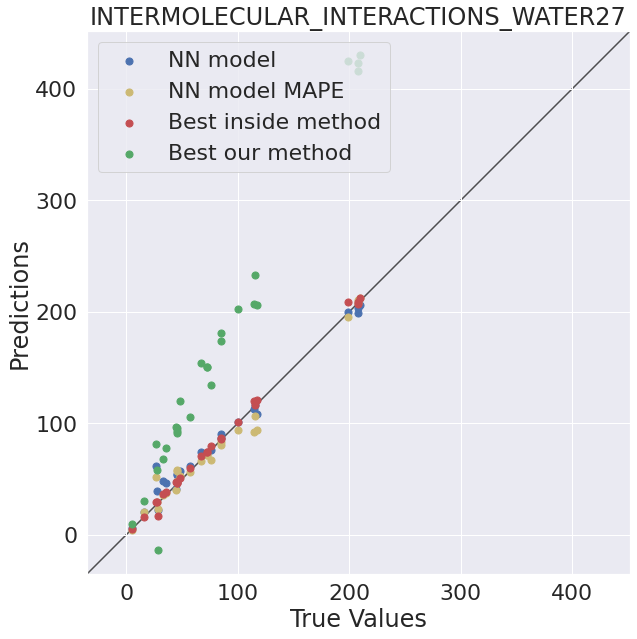

RMSE  LARGE_SYSTEMS  :  31.71
MAPE  LARGE_SYSTEMS  :   0.57
R2    LARGE_SYSTEMS  :   0.98
RMSE MAPE LARGE_SYSTEMS  :  39.68
MAPE MAPE LARGE_SYSTEMS  :   0.74
R2   MAPE LARGE_SYSTEMS  :   0.96


<Figure size 720x720 with 0 Axes>

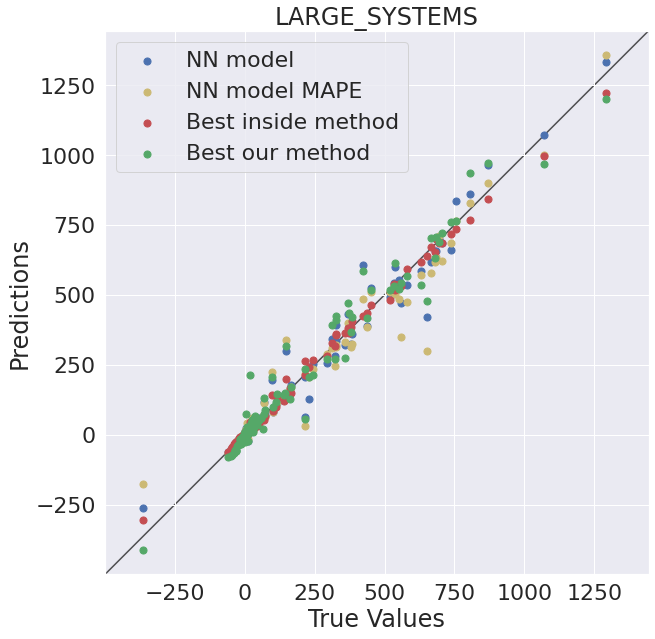

RMSE  LARGE_SYSTEMS_BSR36  :   3.14
MAPE  LARGE_SYSTEMS_BSR36  :   0.13
R2    LARGE_SYSTEMS_BSR36  :   0.91
RMSE MAPE LARGE_SYSTEMS_BSR36  :   1.60
MAPE MAPE LARGE_SYSTEMS_BSR36  :   0.13
R2   MAPE LARGE_SYSTEMS_BSR36  :   0.98


<Figure size 720x720 with 0 Axes>

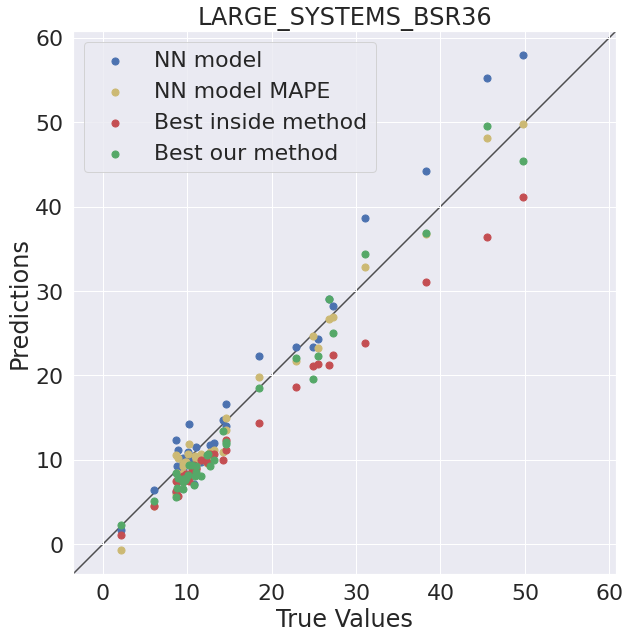

RMSE  LARGE_SYSTEMS_C60ISO  :   8.32
MAPE  LARGE_SYSTEMS_C60ISO  :   0.05
R2    LARGE_SYSTEMS_C60ISO  :   0.96
RMSE MAPE LARGE_SYSTEMS_C60ISO  :   8.27
MAPE MAPE LARGE_SYSTEMS_C60ISO  :   0.07
R2   MAPE LARGE_SYSTEMS_C60ISO  :   0.96


<Figure size 720x720 with 0 Axes>

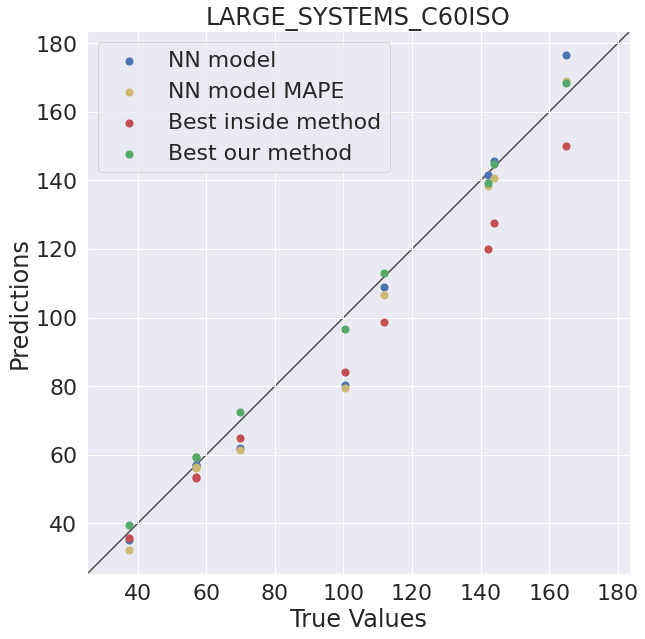

RMSE  LARGE_SYSTEMS_CDIE20  :   2.07
MAPE  LARGE_SYSTEMS_CDIE20  :   0.51
R2    LARGE_SYSTEMS_CDIE20  :   0.68
RMSE MAPE LARGE_SYSTEMS_CDIE20  :   1.26
MAPE MAPE LARGE_SYSTEMS_CDIE20  :   0.31
R2   MAPE LARGE_SYSTEMS_CDIE20  :   0.88


<Figure size 720x720 with 0 Axes>

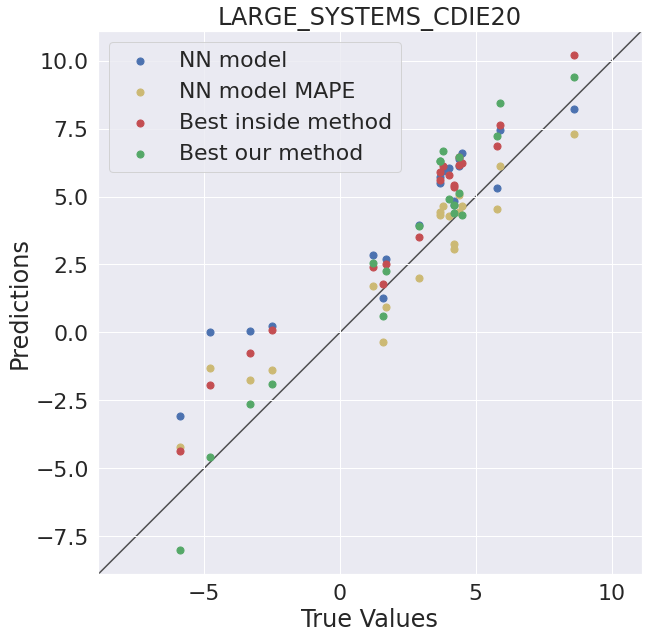

RMSE  LARGE_SYSTEMS_DARC  :   5.88
MAPE  LARGE_SYSTEMS_DARC  :   0.20
R2    LARGE_SYSTEMS_DARC  :   0.79
RMSE MAPE LARGE_SYSTEMS_DARC  :   7.27
MAPE MAPE LARGE_SYSTEMS_DARC  :   0.26
R2   MAPE LARGE_SYSTEMS_DARC  :   0.68


<Figure size 720x720 with 0 Axes>

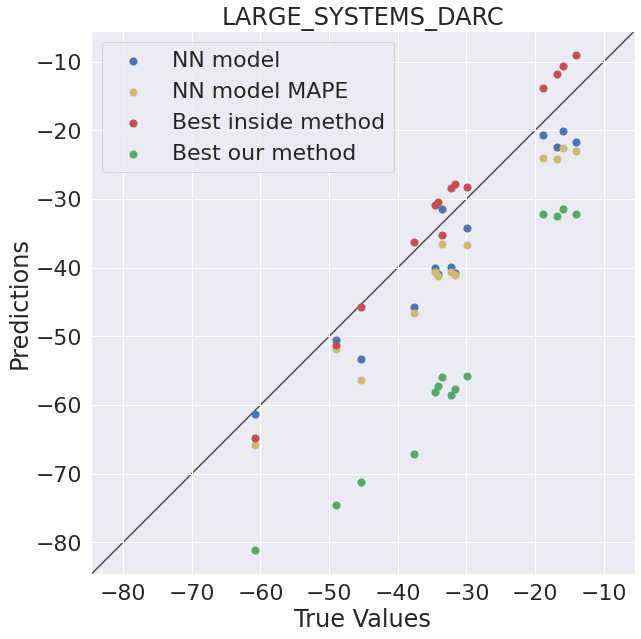

RMSE  LARGE_SYSTEMS_ISO34  :   5.82
MAPE  LARGE_SYSTEMS_ISO34  :   0.45
R2    LARGE_SYSTEMS_ISO34  :   0.83
RMSE MAPE LARGE_SYSTEMS_ISO34  :   6.78
MAPE MAPE LARGE_SYSTEMS_ISO34  :   0.66
R2   MAPE LARGE_SYSTEMS_ISO34  :   0.77


<Figure size 720x720 with 0 Axes>

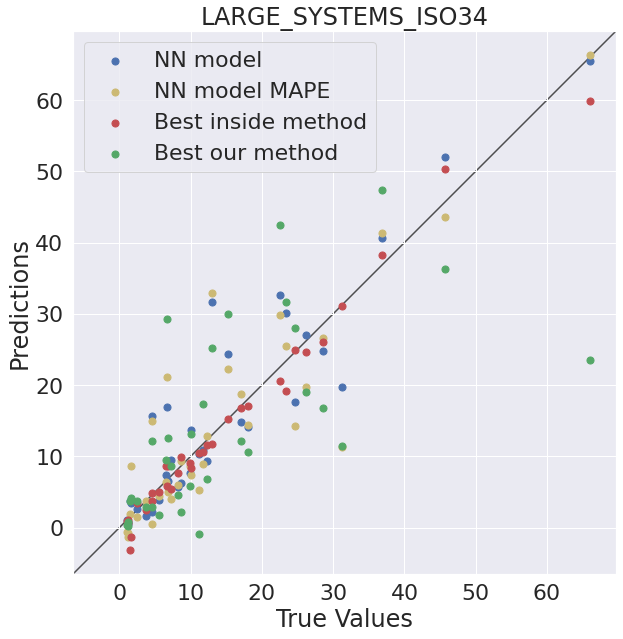

RMSE  LARGE_SYSTEMS_ISOL24  :  12.01
MAPE  LARGE_SYSTEMS_ISOL24  :   1.37
R2    LARGE_SYSTEMS_ISOL24  :   0.56
RMSE MAPE LARGE_SYSTEMS_ISOL24  :  14.71
MAPE MAPE LARGE_SYSTEMS_ISOL24  :   2.45
R2   MAPE LARGE_SYSTEMS_ISOL24  :   0.34


<Figure size 720x720 with 0 Axes>

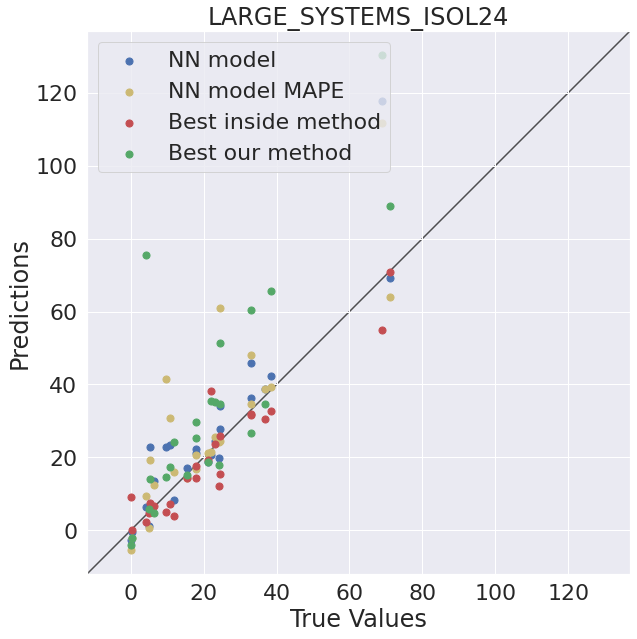

RMSE  LARGE_SYSTEMS_MB16-43  :  74.08
MAPE  LARGE_SYSTEMS_MB16-43  :   0.17
R2    LARGE_SYSTEMS_MB16-43  :   0.94
RMSE MAPE LARGE_SYSTEMS_MB16-43  :  93.10
MAPE MAPE LARGE_SYSTEMS_MB16-43  :   0.18
R2   MAPE LARGE_SYSTEMS_MB16-43  :   0.90


<Figure size 720x720 with 0 Axes>

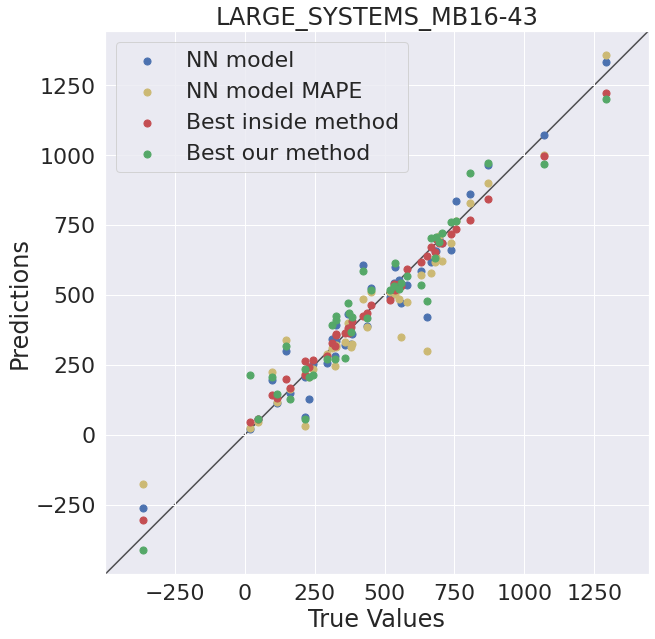

RMSE  LARGE_SYSTEMS_PArel  :   9.51
MAPE  LARGE_SYSTEMS_PArel  :   2.55
R2    LARGE_SYSTEMS_PArel  :  -4.19
RMSE MAPE LARGE_SYSTEMS_PArel  :   8.26
MAPE MAPE LARGE_SYSTEMS_PArel  :   2.68
R2   MAPE LARGE_SYSTEMS_PArel  :  -2.91


<Figure size 720x720 with 0 Axes>

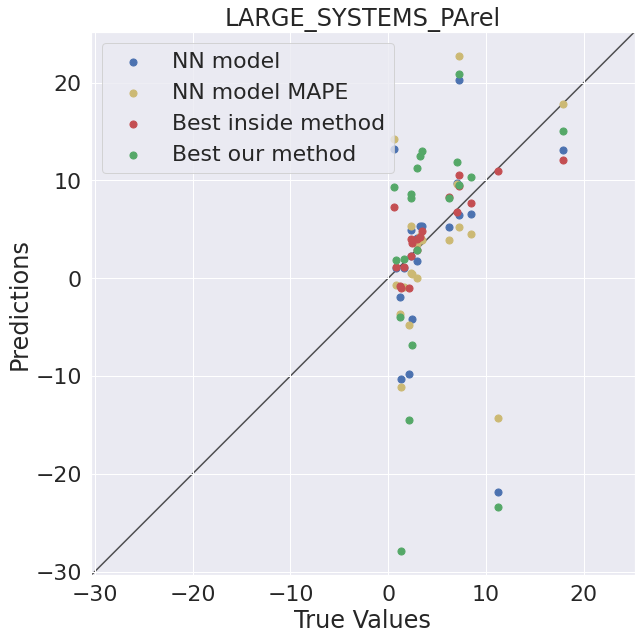

RMSE  LARGE_SYSTEMS_RSE43  :   2.63
MAPE  LARGE_SYSTEMS_RSE43  :   0.36
R2    LARGE_SYSTEMS_RSE43  :   0.87
RMSE MAPE LARGE_SYSTEMS_RSE43  :   2.77
MAPE MAPE LARGE_SYSTEMS_RSE43  :   0.53
R2   MAPE LARGE_SYSTEMS_RSE43  :   0.86


<Figure size 720x720 with 0 Axes>

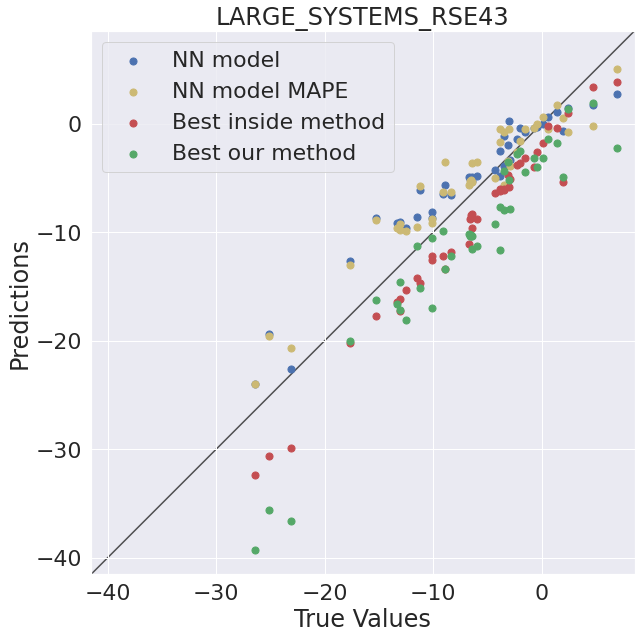

RMSE  Full  :  18.26
MAPE  Full  :   0.93
R2    Full  :   0.99
RMSE MAPE Full  :  19.69
MAPE MAPE Full  :   1.05
R2   MAPE Full  :   0.98


<Figure size 720x720 with 0 Axes>

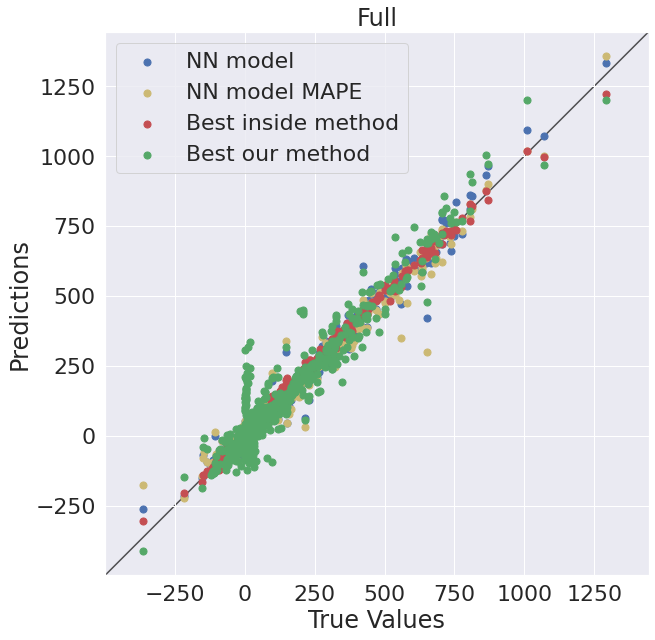

In [17]:
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    y_pred = models_results[setname].y_pred 
    rmse = mean_squared_error(Y, y_pred, squared=False)
    mape = mean_absolute_percentage_error(Y, y_pred)
    r2 = r2_score(Y, y_pred)
    print("RMSE ", setname, " : %6.2f"%rmse)
    print("MAPE ", setname, " : %6.2f"%mape)
    print("R2   ", setname, " : %6.2f"%r2)
    
    y_pred_mape = models_results[setname].y_pred_mape
    rmse = mean_squared_error(Y, y_pred_mape, squared=False)
    mape = mean_absolute_percentage_error(Y, y_pred_mape)
    r2 = r2_score(Y, y_pred_mape)
    print("RMSE MAPE", setname, " : %6.2f"%rmse)
    print("MAPE MAPE", setname, " : %6.2f"%mape)
    print("R2   MAPE", setname, " : %6.2f"%r2)
    plt.clf()
    #plt.scatter(Y, y_pred)

    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='NN model')
    ax.scatter(Y, y_pred_mape, c='y', s=50, label='NN model MAPE')
    ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
                c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()